# Important notes

Project was done by:

- Mateusz Janowski (1240288)
- Zuzanna Rybok (1240360)

# Uploading the dataset for CNN

In [ ]:
# Here you need to upload your kaggle.json API token file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mateuszjanowski","key":"35704b69998f85e4a12a958b864b4a3c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download data from kaggle
!kaggle competitions download -c plant-seedlings-classification


In [ ]:
import zipfile
import os

with zipfile.ZipFile("plant-seedlings-classification.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## EDA

<Figure size 1000x600 with 0 Axes>

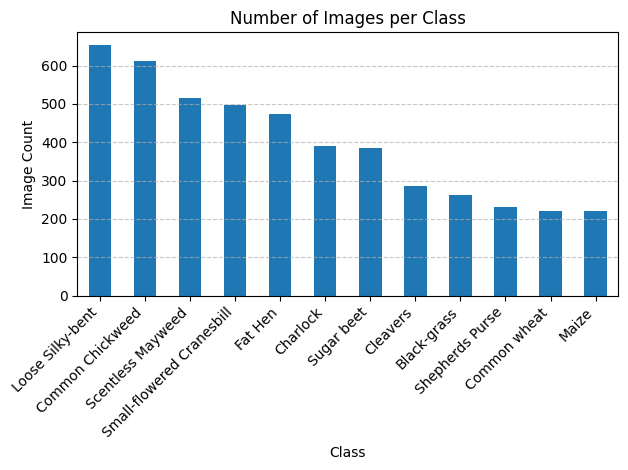

In [ ]:
# Define the path to the training data directory
train_dir = "train"

# Count the number of images per class
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, cls))
}

# Convert the class distribution to a DataFrame and sort
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df_counts = df_counts.sort_values(by='Image Count', ascending=False)

# Plot the class distribution
plt.figure(figsize=(10, 6))
df_counts.plot(kind='bar', legend=False)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

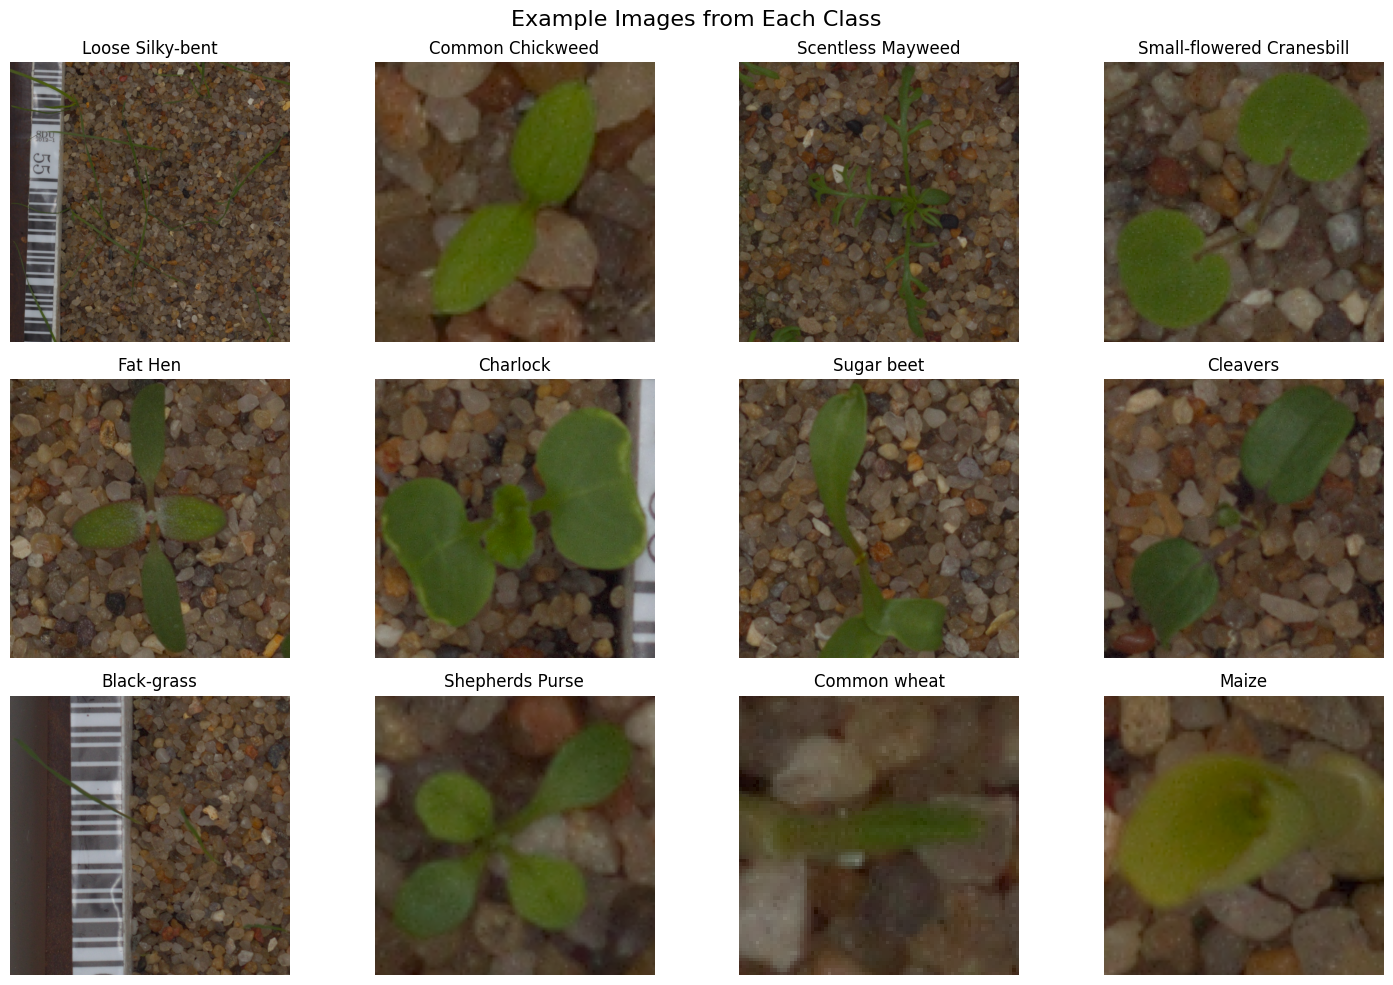

In [ ]:
import random

# Show one random image from each class
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
classes = list(df_counts.index)

for i, ax in enumerate(axs.flat):
    if i < len(classes):
        cls = classes[i]
        image_file = random.choice(os.listdir(os.path.join(train_dir, cls)))
        image_path = os.path.join(train_dir, cls, image_file)
        image = mpimg.imread(image_path)

        ax.imshow(image)
        ax.set_title(cls)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle("Example Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


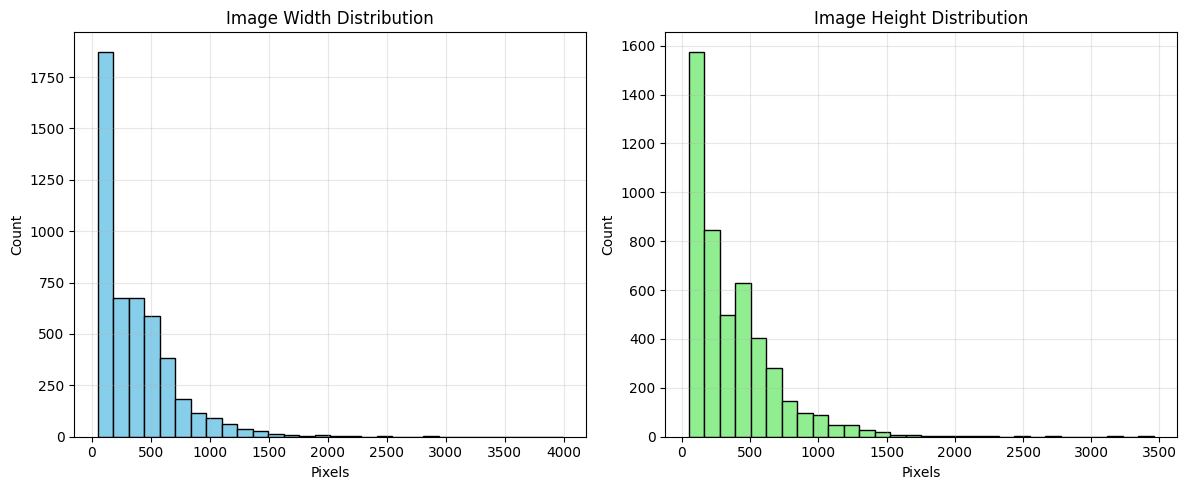

In [ ]:
from PIL import Image

# Collect image shapes (width, height) per class
image_shapes = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    for img_name in os.listdir(cls_dir):
        try:
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)
            image_shapes.append(img.size)  # (width, height)
        except:
            print(f"Could not open image: {img_path}")

# Create a DataFrame with width and height
df_shapes = pd.DataFrame(image_shapes, columns=['width', 'height'])

# Plot width and height distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(df_shapes['width'], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Image Width Distribution')
axs[1].hist(df_shapes['height'], bins=30, color='lightgreen', edgecolor='black')
axs[1].set_title('Image Height Distribution')

for ax in axs:
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



The histograms above illustrate the distribution of image widths (left) and heights (right) across the dataset.

- A majority of the images have relatively small dimensions, with both width and height concentrated between 100 and 600 pixels.
- There is a **long tail** of images with significantly larger dimensions, (beyond 3000 pixels), but these are rare outliers.
- The variability in image sizes suggests that we might need to resize or normalize our dta to ensure consistency before feeding it into a CNN.


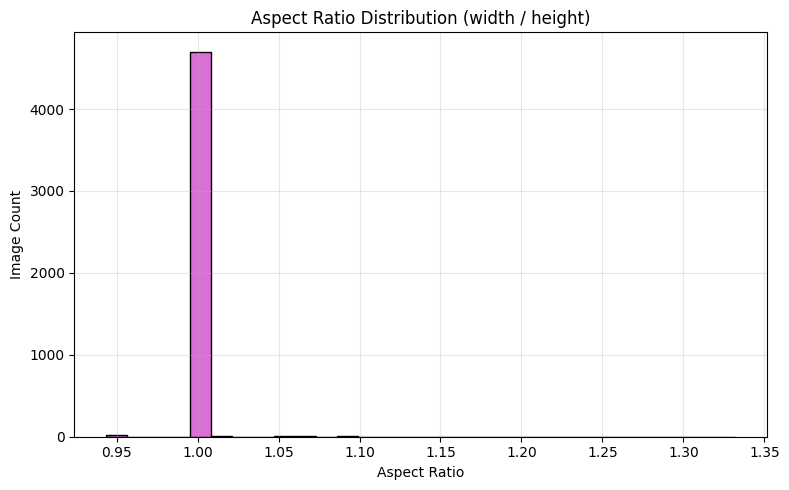

In [ ]:
# Add aspect ratio column
df_shapes['aspect_ratio'] = df_shapes['width'] / df_shapes['height']

# Plot histogram of aspect ratios
plt.figure(figsize=(8, 5))
plt.hist(df_shapes['aspect_ratio'], bins=30, color='orchid', edgecolor='black')
plt.title("Aspect Ratio Distribution (width / height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Image Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The histogram above shows the distribution of aspect ratios (width / height) for all images in the dataset.

- The significant majority of images have an aspect ratio very close to 1, indicating that most images are either square or nearly square.

So as the dataset is mostly composed of square images, standardizing all inputs to a square resolution (e.g., 224×224) during preprocessing it is appropriate and unlikely to distort the image content.


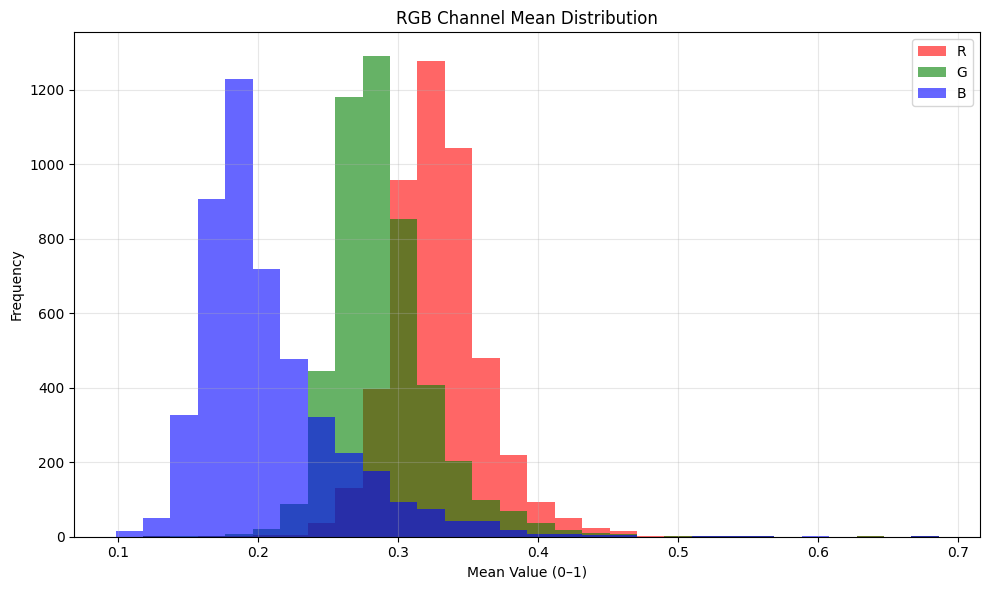

In [ ]:
def compute_rgb_means(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img) / 255.0
        r_mean = np.mean(img_np[:, :, 0])
        g_mean = np.mean(img_np[:, :, 1])
        b_mean = np.mean(img_np[:, :, 2])
        return r_mean, g_mean, b_mean
    except:
        return None

# Compute means for a sample of images (or all if feasible)
rgb_means = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        means = compute_rgb_means(img_path)
        if means:
            rgb_means.append(means)

# Convert to DataFrame
df_rgb = pd.DataFrame(rgb_means, columns=['R', 'G', 'B'])

# Plot histograms of R, G, B with matching colors
df_rgb.plot(kind='hist', bins=30, alpha=0.6, figsize=(10, 6),
            title='RGB Channel Mean Distribution',
            color=['red', 'green', 'blue'])
plt.xlabel("Mean Value (0–1)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Red channel has the highest average intensity values with peak around 0.35, indicating a strong presence of red tones in the dataset.
Most dominant in brightness.

Green channel has lightly lower intensities, peaking around 0.25–0.3 but still contributes significantly to image coloration.

Blue channel has the lowest average intensity, peaking at 0.2. That can suggests less green content or generally darker green tones.

**Conclusion**:
- All three channels show unimodal and distinct distributions, indicating a varied and natural color composition.

- Images are not grayscale and show no signs of being overexposed.

In [ ]:
from PIL import Image
import numpy as np

grayscale_images = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        try:
            img = Image.open(img_path)
            if img.mode == 'L':
                grayscale_images.append(img_path)
            elif img.mode == 'RGB':
                img_array = np.array(img)
                if np.all(img_array[..., 0] == img_array[..., 1]) and np.all(img_array[..., 1] == img_array[..., 2]):
                    grayscale_images.append(img_path)
            else:
                grayscale_images.append(img_path)  # in other modes (RGBA, etc.)
        except:
            grayscale_images.append(img_path)  # unreadable or corrupted

print(f"Found {len(grayscale_images)} grayscale or unreadable images.")
for path in grayscale_images:
    print(path)


Found 24 grayscale or unreadable images.
train/Loose Silky-bent/e513efb9a.png
train/Loose Silky-bent/d31724b7f.png
train/Loose Silky-bent/0cf9eb4ab.png
train/Loose Silky-bent/875ef92d7.png
train/Loose Silky-bent/780b7ab63.png
train/Loose Silky-bent/df615189b.png
train/Loose Silky-bent/5cb45767e.png
train/Loose Silky-bent/3d9f8222d.png
train/Loose Silky-bent/f5602e151.png
train/Loose Silky-bent/ab47c78db.png
train/Loose Silky-bent/881498f15.png
train/Loose Silky-bent/180a7bc07.png
train/Loose Silky-bent/b81690ccf.png
train/Loose Silky-bent/7a8370ede.png
train/Loose Silky-bent/7324d3cc4.png
train/Loose Silky-bent/02b15993e.png
train/Loose Silky-bent/d1653b4c3.png
train/Loose Silky-bent/ae1c97a42.png
train/Loose Silky-bent/4a0df8be4.png
train/Loose Silky-bent/9cf880bda.png
train/Loose Silky-bent/3fd2b83fc.png
train/Black-grass/77629b9e3.png
train/Black-grass/a8ab1ff26.png
train/Black-grass/ae8f69724.png


Through this code we scan the image directory to detect grayscale or corrupted files that cannot be opened as RGB. It identified 21 such images and printed their full paths for manual inspection or removal. These images may cause issues during model training, so it’s recommended to filter them out or convert them to the RGB format.

## Preprocessing

# Approach 1 - Keep grayscale or unreadable images, but convert them to RGB format

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

# Parameters
IMG_SIZE = 96
DATASET_DIR = "train"

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            # Open image, convert to RGB and resize
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0  # Normalize to 0–1
            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")


Images loaded and resized
Image shape: (4750, 96, 96, 3)
Unique classes: 12


To ensure consistency in input data shape and simplify model training, we resize all images to a uniform size of 224×224 pixels, convert all images to RGB format and  normalize pixel values by scaling them to the [0, 1] range. That will help stabilize training and accelerates convergence.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Create label-to-index mapping
label_to_index = {label: idx for idx, label in enumerate(np.unique(y))}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Encode string labels to integer indices
y_encoded = np.array([label_to_index[label] for label in y])

# One-hot encode labels
y_categorical = to_categorical(y_encoded, num_classes=len(label_to_index))

# Split 1: train and test1 (70% / 30%)
X_train, X_test1, y_train, y_test1 = train_test_split(
    X, y_categorical, test_size=0.30, stratify=y_categorical, random_state=42
)

# Split 2: test1 into val and test (50%/50% of 30% => 15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test1, y_test1, test_size=0.50, stratify=y_test1, random_state=42
)


print("Labels encoded and data split finished.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Labels encoded and data split finished.
X_train shape: (3325, 96, 96, 3)
y_train shape: (3325, 12)
X_val shape:   (712, 96, 96, 3)
y_val shape:   (712, 12)
X_test shape:  (713, 96, 96, 3)
y_test shape:  (713, 12)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Ustawienia dla segmentacji zieleni ---
lower_green = (25, 40, 50)
upper_green = (75, 255, 255)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

# --- Funkcja preprocessingu ---
def preprocess_images(X):
    preprocessed = []
    for img in X:
        # 1. Zamiana na uint8 (0–255)
        img_uint8 = (img * 255).astype(np.uint8)

        # 2. (Opcjonalnie resize - u Ciebie obrazy są 224x224, więc nie zmniejszamy!)
        resize_img = img_uint8

        # 3. Rozmycie Gaussa
        Gblur_img = cv2.GaussianBlur(resize_img, (3, 3), 0)

        # 4. Konwersja do HSV
        hsv_img = cv2.cvtColor(Gblur_img, cv2.COLOR_RGB2HSV)  # RGB -> HSV

        # 5. Segmentacja zieleni
        mask = cv2.inRange(hsv_img, lower_green, upper_green)

        # 6. Morfologiczne operacje czyszczące
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 7. Boolean mask
        bMask = mask > 0

        # 8. Nałożenie maski na obraz
        clearImg = np.zeros_like(resize_img, np.uint8)
        clearImg[bMask] = resize_img[bMask]

        # 9. Konwersja do float32 (0–1)
        clearImg_float = clearImg.astype(np.float32) / 255.0

        preprocessed.append(clearImg_float)

    return np.asarray(preprocessed)

# --- Preprocessing Twoich danych (przykład dla X_train) ---
X_train_cleaned = preprocess_images(X_train)
X_val_cleaned = preprocess_images(X_val)
X_test_cleaned = preprocess_images(X_test)


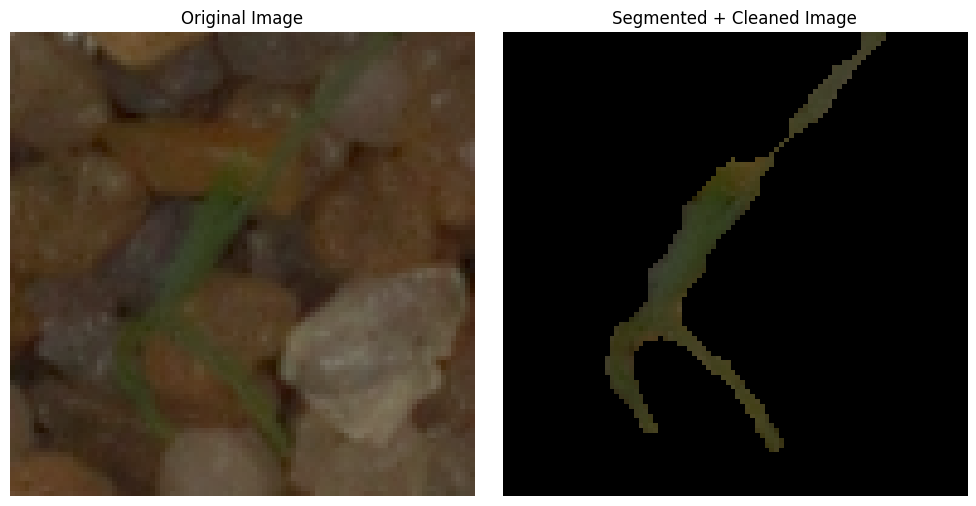

In [ ]:
# --- Wyświetlanie przykładowego obrazu (losowego) ---

# Losowy indeks
i = np.random.randint(0, len(X_train))

# Oryginalny obraz i przetworzony obraz
original = X_train[i]
processed = X_train_cleaned[i]

# Tworzenie wykresu
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original)
axs[0].set_title("Original Image")

axs[1].imshow(processed)
axs[1].set_title("Segmented + Cleaned Image")

# Wyłączenie osi
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


Further cleaning images and focus on removing background based on green hue range, filling small holes and removing noises in the binary mask and sharpening edges and structural features of the plants.

The resulting image retains only the relevant plant area and is normalized to [0, 1] for use in the CNN model.


In [ ]:
print(f"Cleaned training shape: {X_train_cleaned.shape}")
print(f"Cleaned validation shape: {X_val_cleaned.shape}")
print(f"Cleaned test shape: {X_test_cleaned.shape}")


Cleaned training shape: (3325, 96, 96, 3)
Cleaned validation shape: (712, 96, 96, 3)
Cleaned test shape: (713, 96, 96, 3)


Full cleaning:

- Cropped to retain only the seedling,
- Morphologically cleaned of artifacts,
- Sharpened to highlight structural features,
- Normalized to the range [0, 1].

## Model Building

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

ins = X_train_cleaned.shape[1:]



# 1. Overfitted model
def build_overfitted_model(input_shape=(ins[0], ins[1], ins[2]), num_classes=12):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model




# 2. Best Model (should be around 85% val acc)
def build_best_model(input_shape=(ins[0], ins[1], ins[2]), num_classes=12):
    model = Sequential()

    # 1st Convolutional Block
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 3rd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))  # No padding
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten before Dense layers
    model.add(Flatten())

    # Fully Connected Layers
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model



## Running models with no callbacks to see the performance

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3334 - loss: 2.0493 - precision: 0.5576 - recall: 0.1187 - val_accuracy: 0.4916 - val_loss: 1.4422 - val_precision: 0.7045 - val_recall: 0.2444
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7163 - loss: 0.8223 - precision: 0.8240 - recall: 0.5979 - val_accuracy: 0.4972 - val_loss: 1.5723 - val_precision: 0.5679 - val_recall: 0.4171
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9833 - loss: 0.0714 - precision: 0.9895 - recall: 0.9771 - val_accuracy: 0.5225 - val_loss: 2.2926 - val_precision: 0.5512 - val_recall: 0.4986
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9983 - loss: 0.0138 - precision: 0.9983 - recall: 0.9983 - val_accuracy: 0.4958 - val_loss: 2.6392 - val_precision: 0.5169 - val_recall: 0.4719
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9998 - loss: 0.0029 - precision: 0.9998 - recall: 0.9996 - val_accuracy: 0.5154 - val_loss: 2

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4296 - loss: 4.4027 - precision: 0.4474 - recall: 0.4204


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy:  0.4544179439544678
Precision:  0.4711964428424835
Recall:  0.4474053382873535


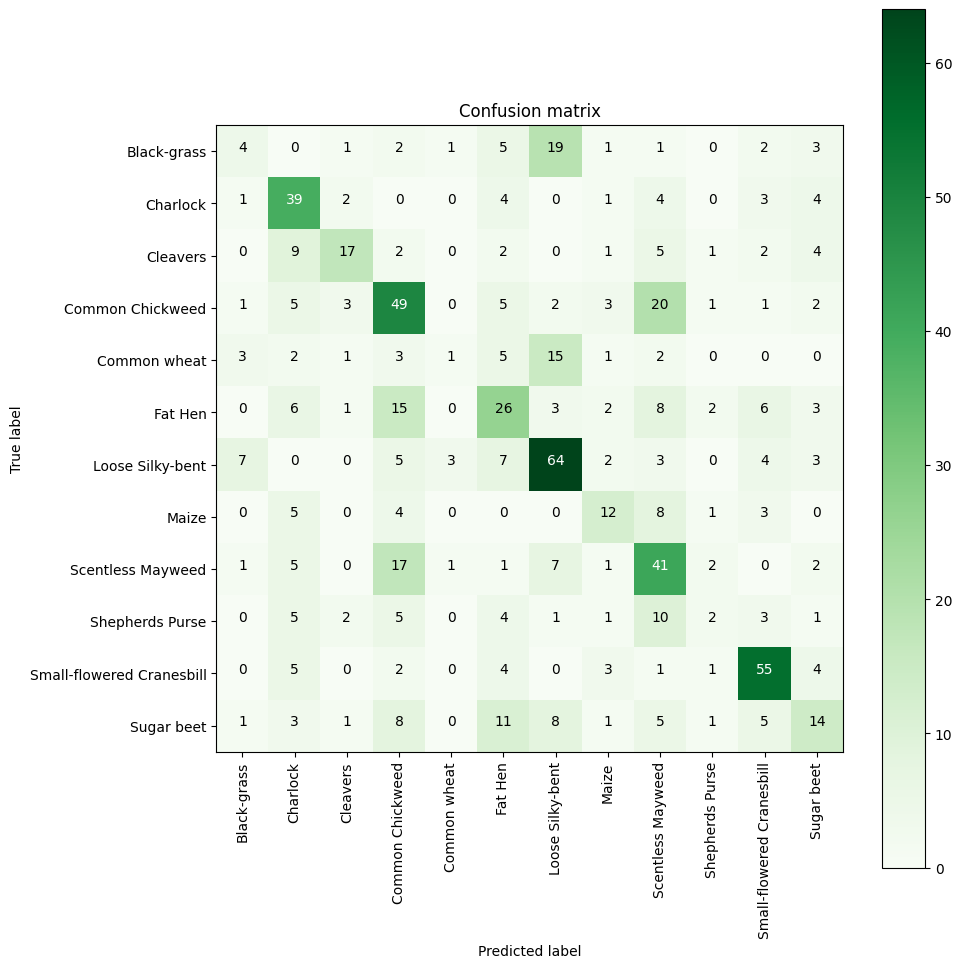

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)


history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3023 - loss: 2.3181 - precision: 0.4066 - recall: 0.1930 - val_accuracy: 0.1053 - val_loss: 6.9002 - val_precision: 0.1085 - val_recall: 0.0983
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5609 - loss: 1.3306 - precision: 0.6695 - recall: 0.4346 - val_accuracy: 0.5267 - val_loss: 1.6001 - val_precision: 0.5792 - val_recall: 0.4621
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6271 - loss: 1.1068 - precision: 0.7176 - recall: 0.5252 - val_accuracy: 0.5758 - val_loss: 1.5126 - val_precision: 0.6327 - val_recall: 0.5225
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6758 - loss: 0.9502 - precision: 0.7612 - recall: 0.5980 - val_accuracy: 0.5449 - val_loss: 1.7636 - val_precision: 0.5753 - val_recall: 0.4831
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7267 - loss: 0.7993 - precision: 0.7895 - recall: 0.6528 - val_accuracy: 0.6180 - val_loss: 

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7823 - loss: 1.1411 - precision: 0.7974 - recall: 0.7669


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy:  0.7755960822105408
Precision:  0.7887930870056152
Recall:  0.7699859738349915


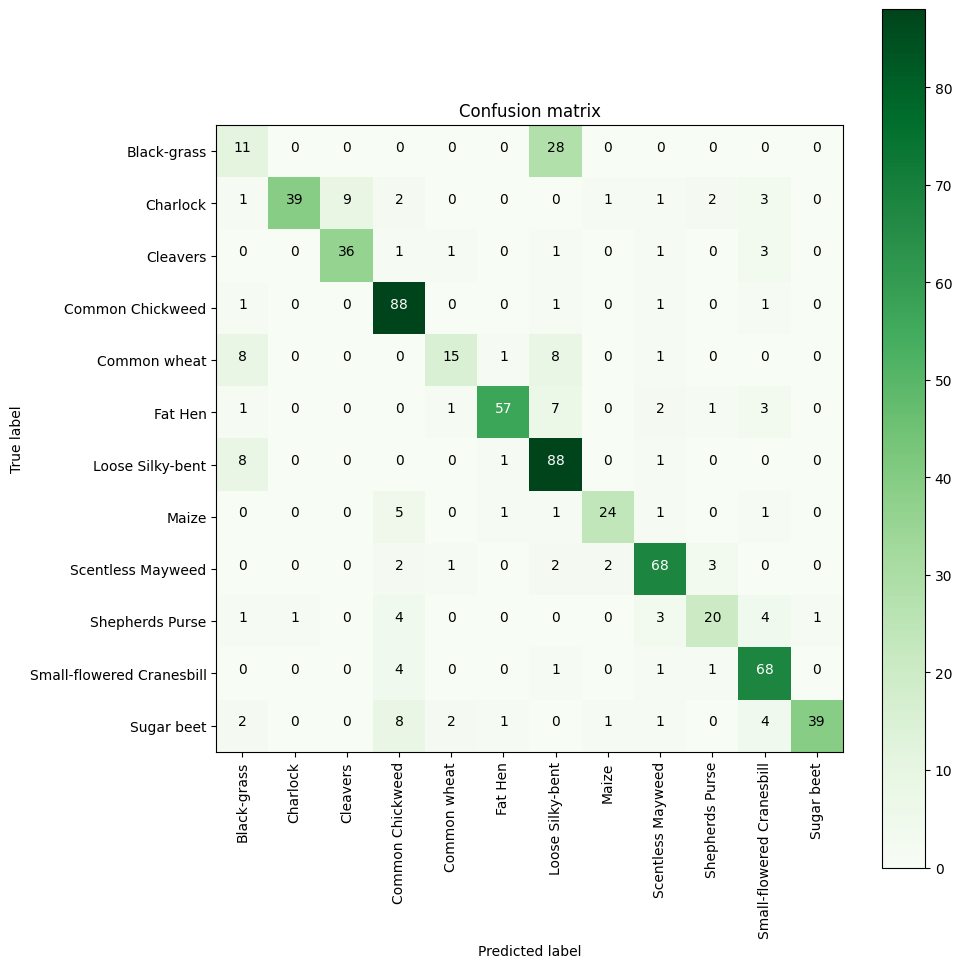

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 1, no callbacks

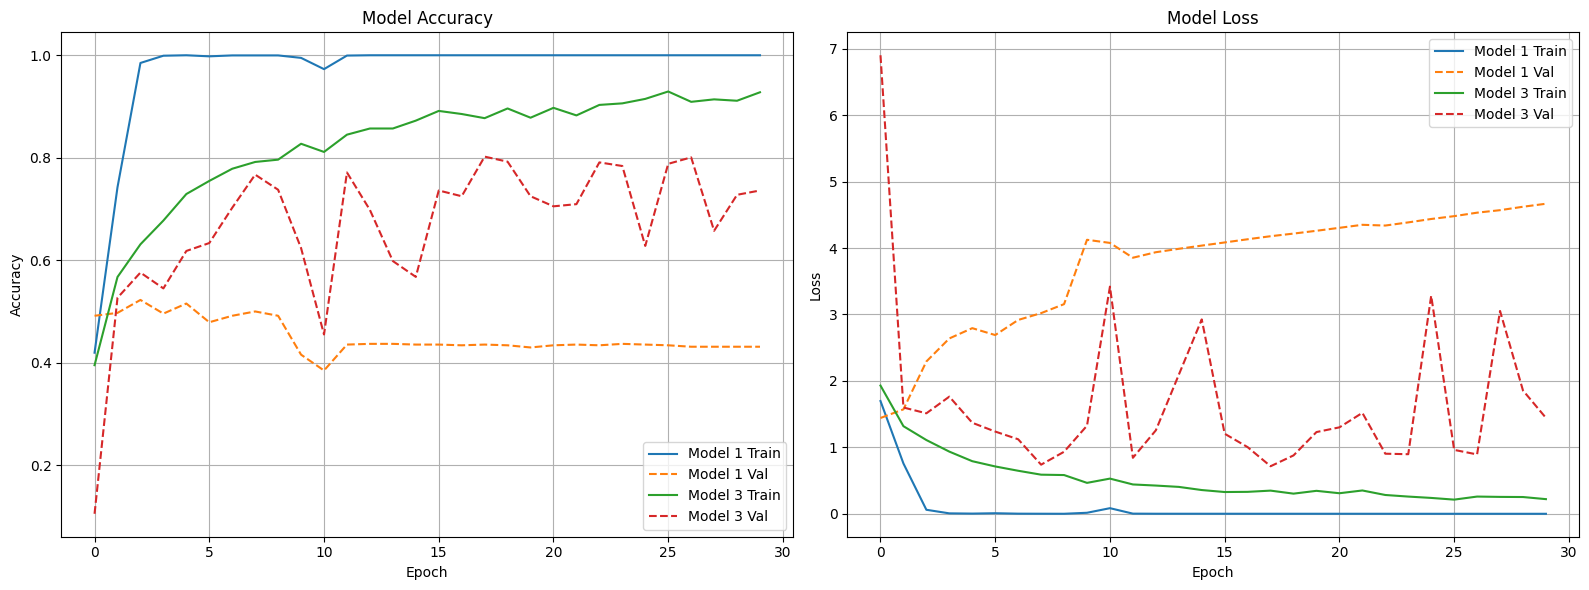

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running models with callbacks

To stabilize the model's validation loss we add callback to reduce learning_rate by 10%. We also add Early stopping to prevent overfitting

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    callbacks = callbacks
)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2819 - loss: 2.1896 - precision: 0.5172 - recall: 0.0831 - val_accuracy: 0.5267 - val_loss: 1.4334 - val_precision: 0.6366 - val_recall: 0.3567 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7139 - loss: 0.8651 - precision: 0.8191 - recall: 0.5875 - val_accuracy: 0.6124 - val_loss: 1.2242 - val_precision: 0.6974 - val_recall: 0.5211 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9685 - loss: 0.1317 - precision: 0.9788 - recall: 0.9578 - val_accuracy: 0.5871 - val_loss: 1.7798 - val_precision: 0.6157 - val_recall: 0.5604 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9966 - loss: 0.0161 - precision: 0.9991 - recall: 0.9951 - val_accuracy: 0.5758 - val_loss: 2.0888 - val_precision: 0.6104 - val_recall: 0.5590 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy:

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6155 - loss: 1.2096 - precision: 0.6870 - recall: 0.5070


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy:  0.6044880747795105
Precision:  0.6792452931404114
Recall:  0.5049088597297668


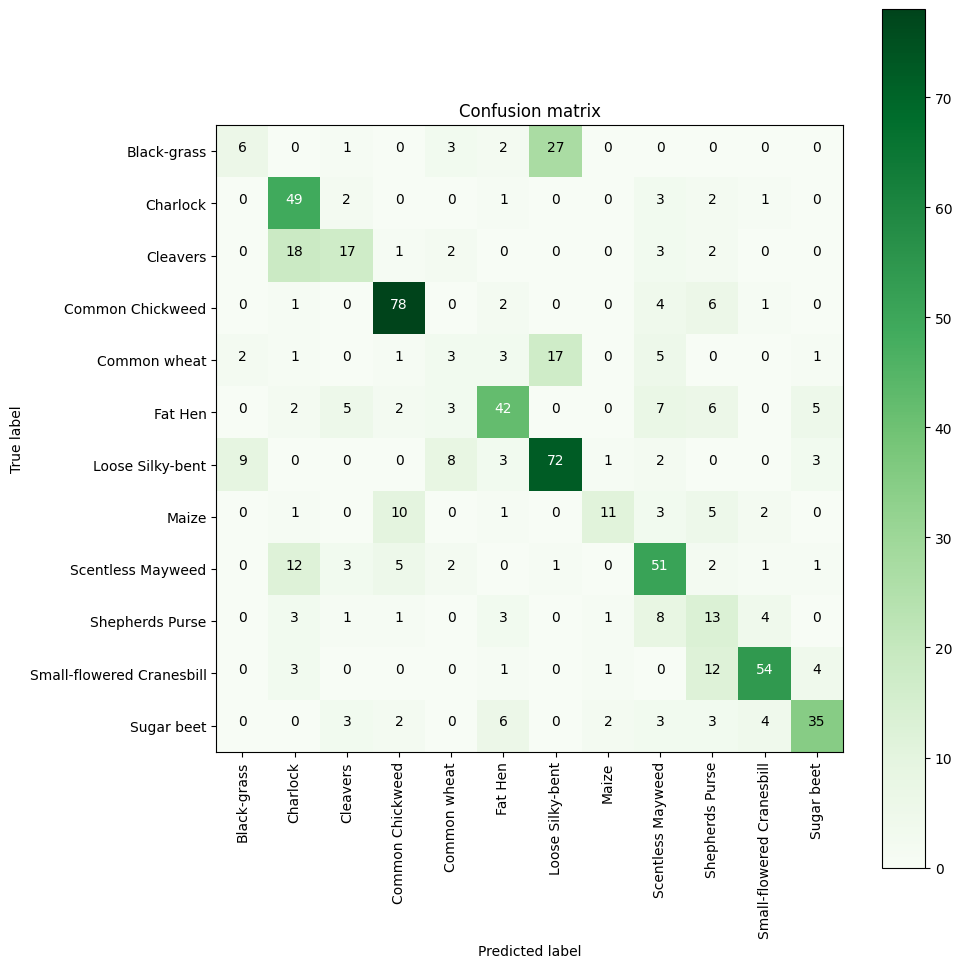

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True,
    callbacks = callbacks
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2838 - loss: 2.3662 - precision: 0.3751 - recall: 0.1704 - val_accuracy: 0.1152 - val_loss: 5.1573 - val_precision: 0.1258 - val_recall: 0.1053 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5512 - loss: 1.3540 - precision: 0.6535 - recall: 0.4374 - val_accuracy: 0.5253 - val_loss: 1.3852 - val_precision: 0.6445 - val_recall: 0.4354 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6248 - loss: 1.0655 - precision: 0.7214 - recall: 0.5221 - val_accuracy: 0.5028 - val_loss: 2.0365 - val_precision: 0.5452 - val_recall: 0.4747 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6805 - loss: 0.9314 - precision: 0.7526 - recall: 0.6002 - val_accuracy: 0.3610 - val_loss: 2.6328 - val_precision: 0.3879 - val_recall: 0.3329 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8302 - loss: 0.6140 - precision: 0.8449 - recall: 0.8259


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Accuracy:  0.8232818841934204
Precision:  0.8362069129943848
Recall:  0.8162692785263062


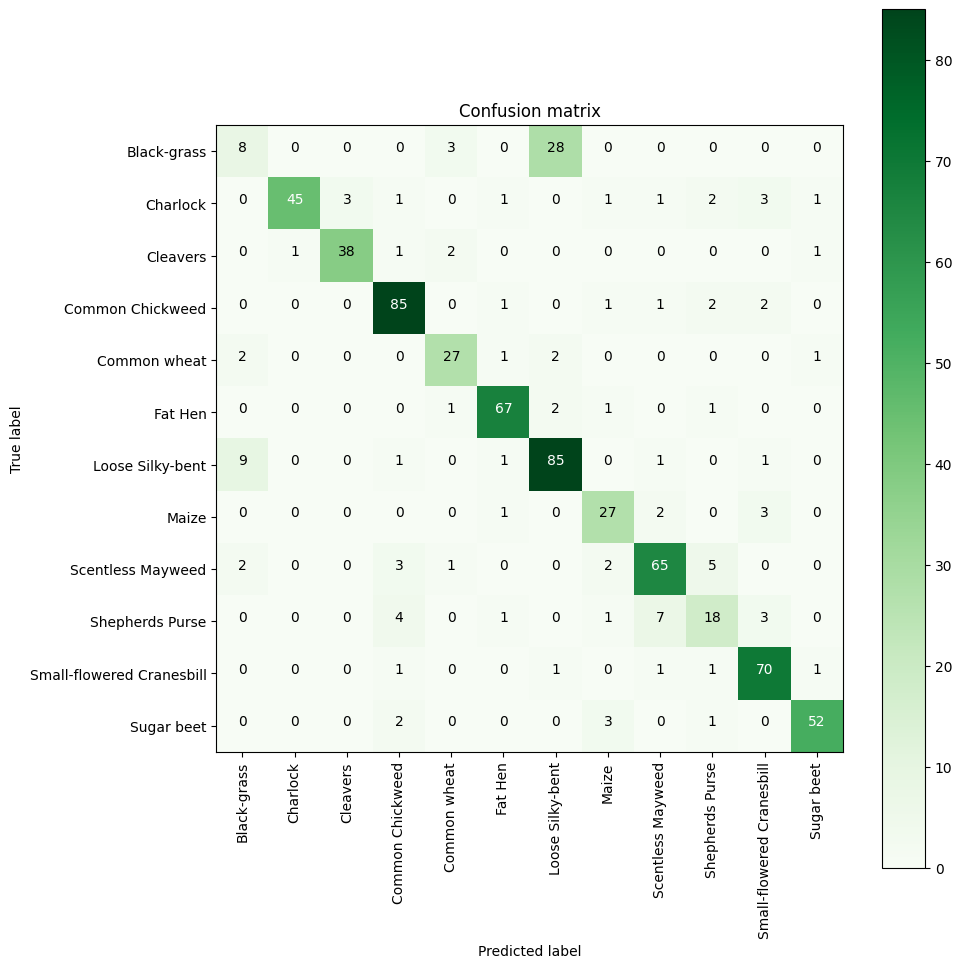

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 1, with callbacks

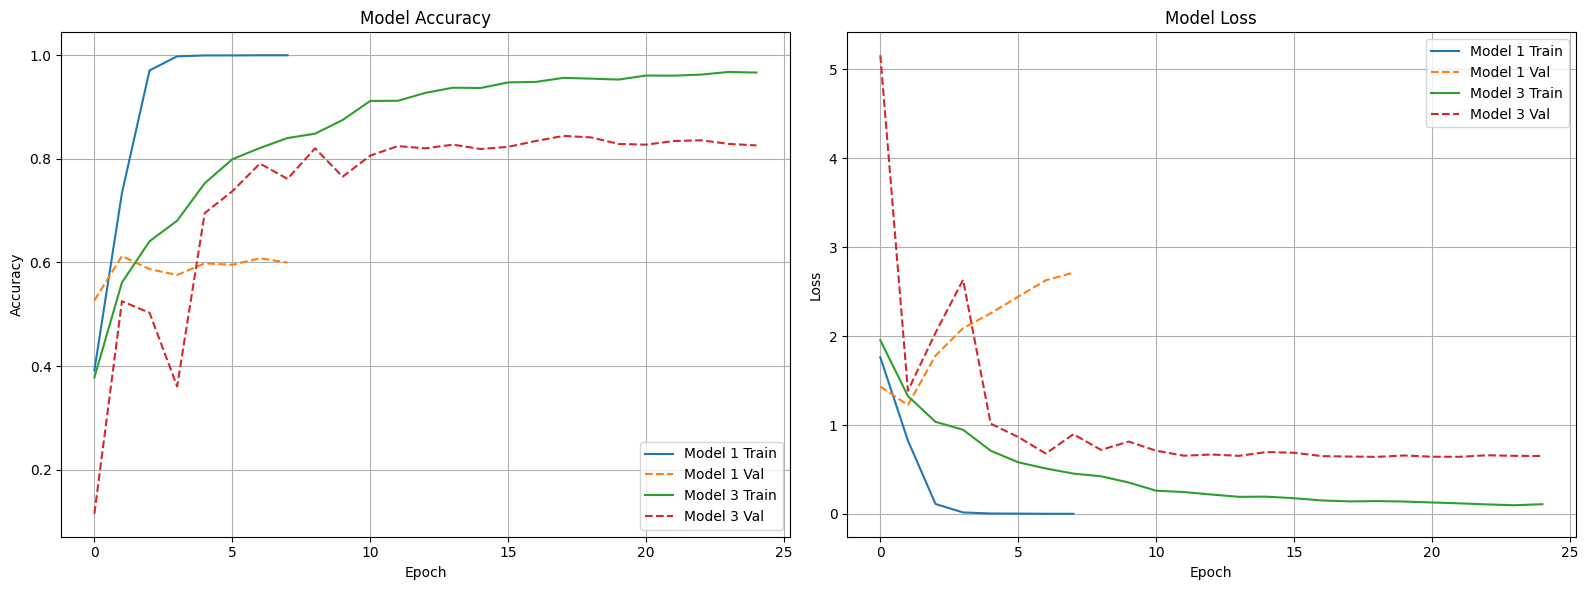

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Adding data-augmentation and running models with it

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_augmented_generator(X_train, y_train, batch_size=8):
    datagen = ImageDataGenerator(
        rotation_range=10,             # slight rotation, plants don't rotate much
        width_shift_range=0.05,        # small horizontal shifts
        height_shift_range=0.05,       # small vertical shifts
        zoom_range=0.05,               # light zoom to simulate camera distance
        horizontal_flip=True,          # mirror symmetry of plants
        fill_mode='nearest'            # filling strategy for transformed pixels
    )

    return datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_overfitted_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3511 - loss: 2.0235 - precision_20: 0.5813 - recall_20: 0.1407 - val_accuracy: 0.6138 - val_loss: 1.1477 - val_precision_20: 0.7431 - val_recall_20: 0.4508 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6237 - loss: 1.1002 - precision_20: 0.7587 - recall_20: 0.4886 - val_accuracy: 0.6699 - val_loss: 1.0076 - val_precision_20: 0.7425 - val_recall_20: 0.5548 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6693 - loss: 0.9629 - precision_20: 0.7598 - recall_20: 0.5460 - val_accuracy: 0.7051 - val_loss: 0.9007 - val_precision_20: 0.7971 - val_recall_20: 0.6180 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6974 - loss: 0.8980 - precision_20: 0.7734 - recall_20: 0.6025 - val_accuracy: 0.7107 - val_loss: 0.8544 - val_precision_20: 0.7688 - val_recall_20: 0.6447 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy:  0.8232818841934204
Precision:  0.8362069129943848
Recall:  0.8162692785263062


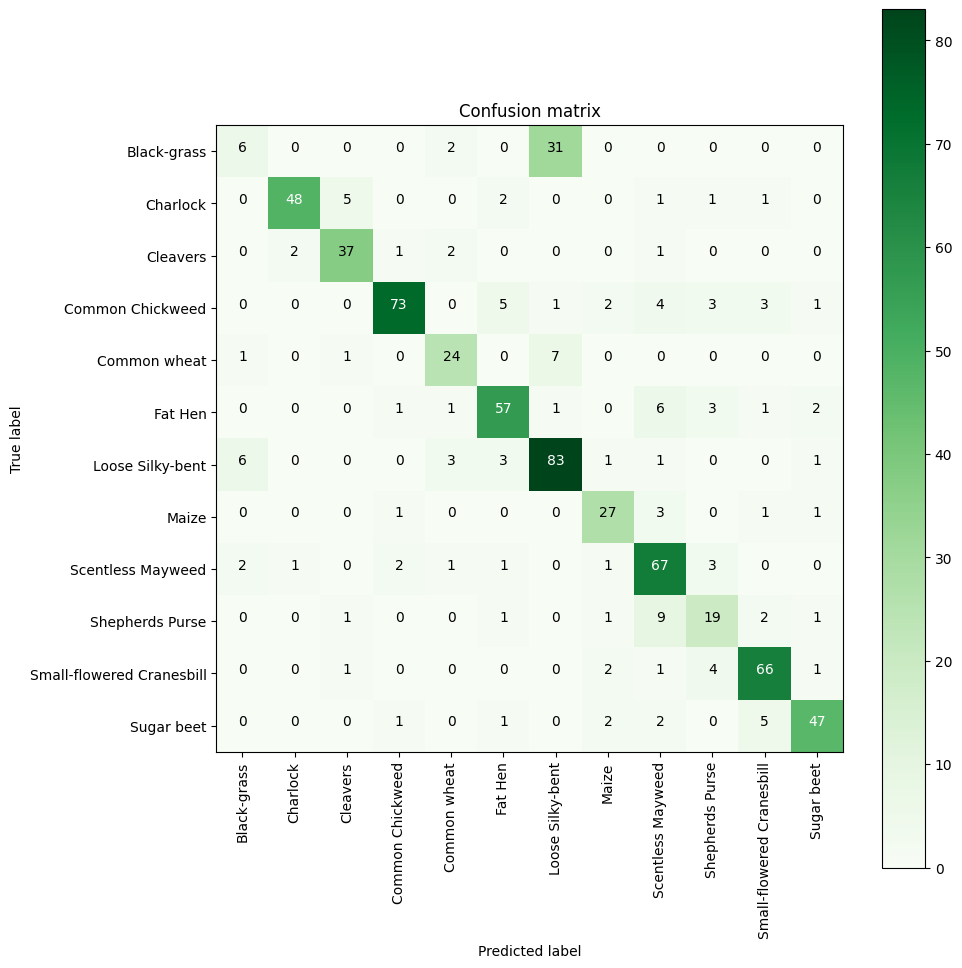

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_best_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3103 - loss: 2.3662 - precision_21: 0.4147 - recall_21: 0.2015 - val_accuracy: 0.0758 - val_loss: 7.7896 - val_precision_21: 0.0758 - val_recall_21: 0.0758 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5114 - loss: 1.5084 - precision_21: 0.6152 - recall_21: 0.3887 - val_accuracy: 0.4003 - val_loss: 2.9580 - val_precision_21: 0.4311 - val_recall_21: 0.3778 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5771 - loss: 1.2568 - precision_21: 0.6586 - recall_21: 0.4693 - val_accuracy: 0.3511 - val_loss: 3.4893 - val_precision_21: 0.3843 - val_recall_21: 0.3427 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6203 - loss: 1.1489 - precision_21: 0.7105 - recall_21: 0.5102 - val_accuracy: 0.4874 - val_loss: 2.0942 - val_precision_21: 0.5246 - val_recall_21: 0.4635 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8807 - loss: 0.3617 - precision_21: 0.8871 - recall_21: 0.8669


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Accuracy:  0.8625525832176208
Precision:  0.8759018778800964
Recall:  0.851332426071167


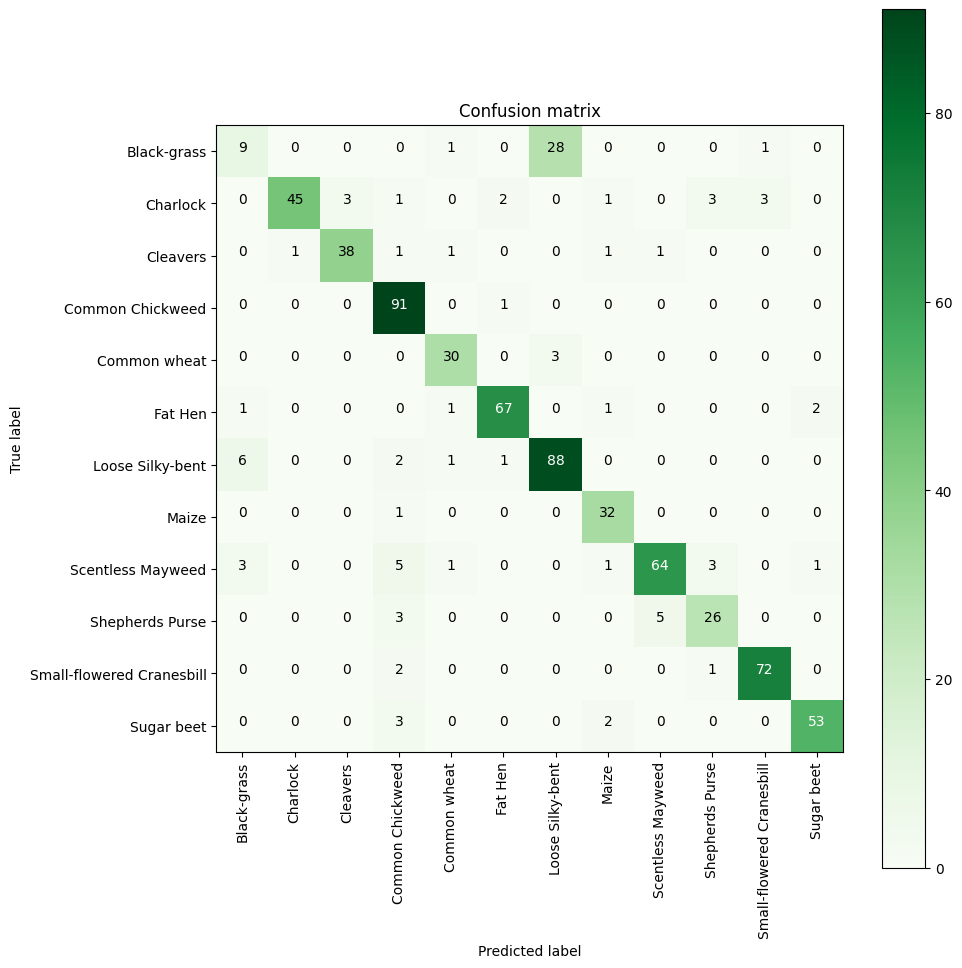

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 1, with callbacks and data augmentation

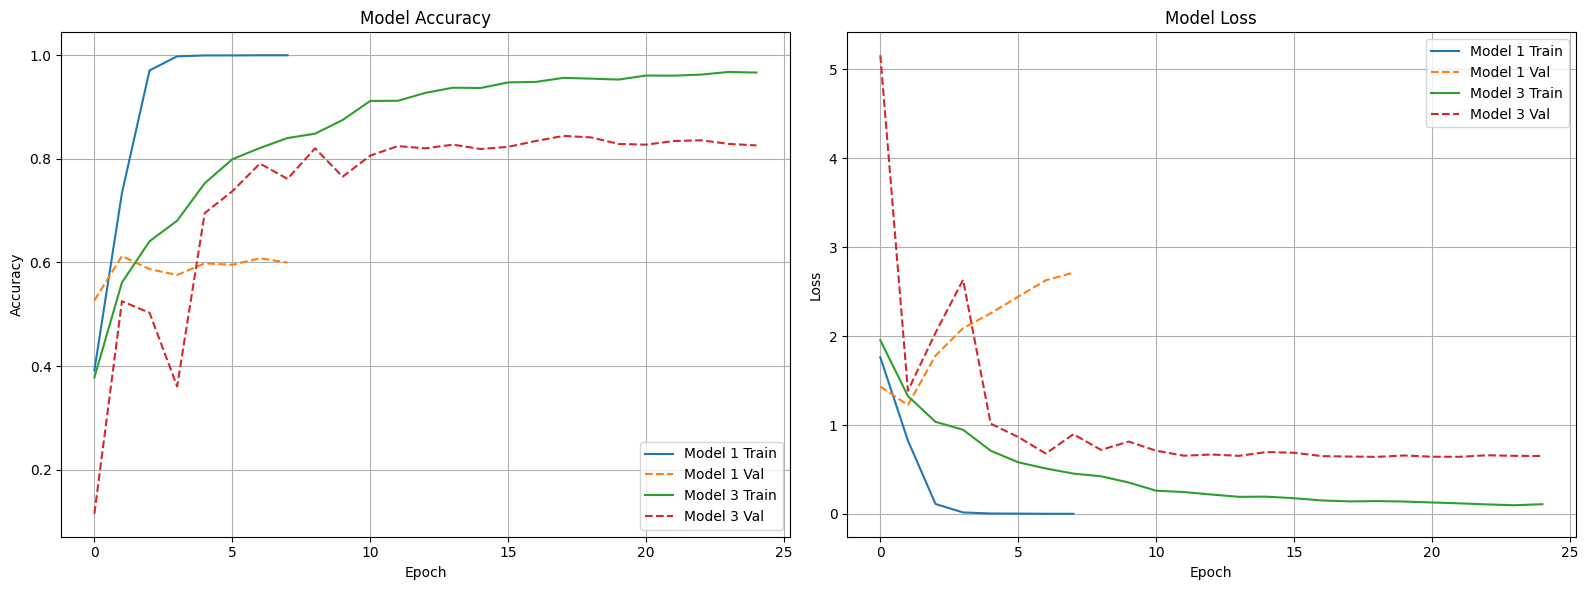

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running the pre-trained MobilNet model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

def build_mobilenet_model(input_shape=(96,96, 3), num_classes=12):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    return model


In [ ]:
model = build_mobilenet_model(input_shape=ins, num_classes=12)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# 4. Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# 5. Augmented data generator
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# 6. Train the model
history_resnet = model.fit(
    train_gen,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    callbacks=callbacks
)

<ipython-input-96-84eae3ed8bb1>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2101']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


416/416 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.3406 - loss: 2.1823 - precision_24: 0.5353 - recall_24: 0.1553 - val_accuracy: 0.5730 - val_loss: 1.2929 - val_precision_24: 0.7217 - val_recall_24: 0.4115 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5561 - loss: 1.2569 - precision_24: 0.6969 - recall_24: 0.3852 - val_accuracy: 0.6770 - val_loss: 1.0070 - val_precision_24: 0.7585 - val_recall_24: 0.5646 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6189 - loss: 1.0838 - precision_24: 0.7270 - recall_24: 0.4981 - val_accuracy: 0.6657 - val_loss: 0.9753 - val_precision_24: 0.7552 - val_recall_24: 0.5590 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6176 - loss: 1.0522 - precision_24: 0.7249 - recall_24: 0.5083 - val_accuracy: 0.6306 - val_loss: 1.0462 - val_precision_24: 0.7208 - val_recall_24: 0.5365 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7309 - loss: 0.7712 - precision_24: 0.8015 - recall_24: 0.6828


## Results of pre-trained model

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2101']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step
Accuracy:  0.739130437374115
Precision:  0.8033058047294617
Recall:  0.6816269159317017


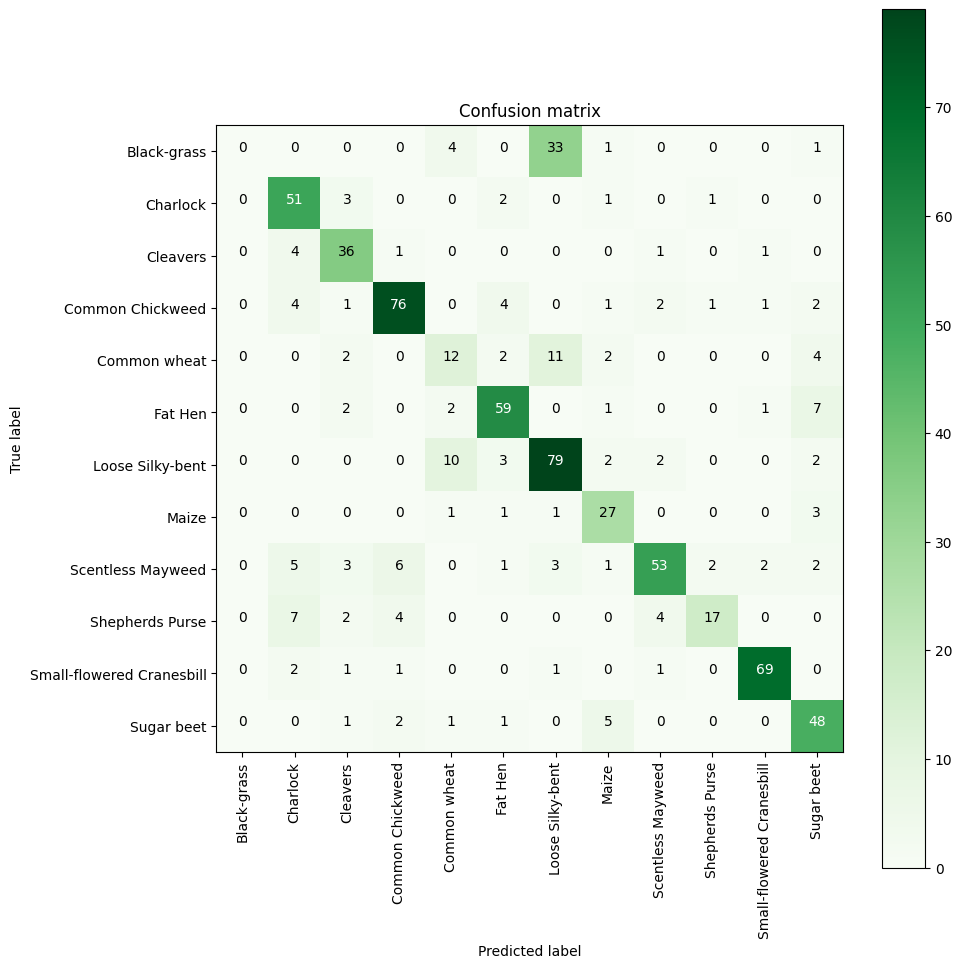

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



# Approach 2 - Keeping grayscale images in the training set and NOT CHANGING THEM TO RGB - instead changing all images to greyscale (96,96,1)






In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

# Parameters
IMG_SIZE = 96
DATASET_DIR = "train"

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            # Open image, convert them to greyscale and resize
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0  # Normalize to 0–1
            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")


Images loaded and resized
Image shape: (4750, 96, 96, 1)
Unique classes: 12


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Create label-to-index mapping
label_to_index = {label: idx for idx, label in enumerate(np.unique(y))}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Encode string labels to integer indices
y_encoded = np.array([label_to_index[label] for label in y])

# One-hot encode labels
y_categorical = to_categorical(y_encoded, num_classes=len(label_to_index))

# Split 1: train and test1 (70% / 30%)
X_train, X_test1, y_train, y_test1 = train_test_split(
    X, y_categorical, test_size=0.30, stratify=y_categorical, random_state=42
)

# Split 2: test1 into val and test (50%/50% of 30% => 15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test1, y_test1, test_size=0.50, stratify=y_test1, random_state=42
)


print("Labels encoded and data split finished.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Labels encoded and data split finished.
X_train shape: (3325, 96, 96, 1)
y_train shape: (3325, 12)
X_val shape:   (712, 96, 96, 1)
y_val shape:   (712, 12)
X_test shape:  (713, 96, 96, 1)
y_test shape:  (713, 12)


In [ ]:
def preprocess_images_grayscale(X):
    preprocessed = []
    for img in X:
        # 1. Konwersja do uint8
        img_uint8 = (img * 255).astype(np.uint8)  # shape: (96, 96, 1)

        # 2. Usunięcie wymiaru kanału (z (96,96,1) do (96,96)) jeśli trzeba
        img_gray = img_uint8.squeeze()

        # 3. Rozmycie Gaussa
        blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)

        # 4. (Opcjonalnie) adaptacyjne wyostrzenie kontrastu – CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(blurred)

        # 5. Morfologiczne oczyszczanie (opcjonalne)
        cleaned = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, kernel)

        # 6. Przeskalowanie do 0–1 i przywrócenie wymiaru kanału
        final_img = (cleaned.astype(np.float32) / 255.0)[..., np.newaxis]  # shape: (96,96,1)

        preprocessed.append(final_img)

    return np.array(preprocessed)


## Running models with no callbacks to see the performance

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2899 - loss: 2.1924 - precision: 0.4776 - recall: 0.0897 - val_accuracy: 0.4916 - val_loss: 1.4205 - val_precision: 0.6522 - val_recall: 0.3581
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7483 - loss: 0.7750 - precision: 0.8444 - recall: 0.6336 - val_accuracy: 0.6278 - val_loss: 1.1326 - val_precision: 0.6817 - val_recall: 0.5716
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9845 - loss: 0.0673 - precision: 0.9911 - recall: 0.9805 - val_accuracy: 0.5590 - val_loss: 1.7047 - val_precision: 0.5938 - val_recall: 0.5379
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9945 - loss: 0.0187 - precision: 0.9945 - recall: 0.9934 - val_accuracy: 0.5983 - val_loss: 1.7915 - val_precision: 0.6259 - val_recall: 0.5829
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9999 - loss: 0.0016 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.5913 - val_loss: 2

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4939 - loss: 3.3128 - precision: 0.5155 - recall: 0.4757


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy:  0.5007012486457825
Precision:  0.5179104208946228
Recall:  0.48667600750923157


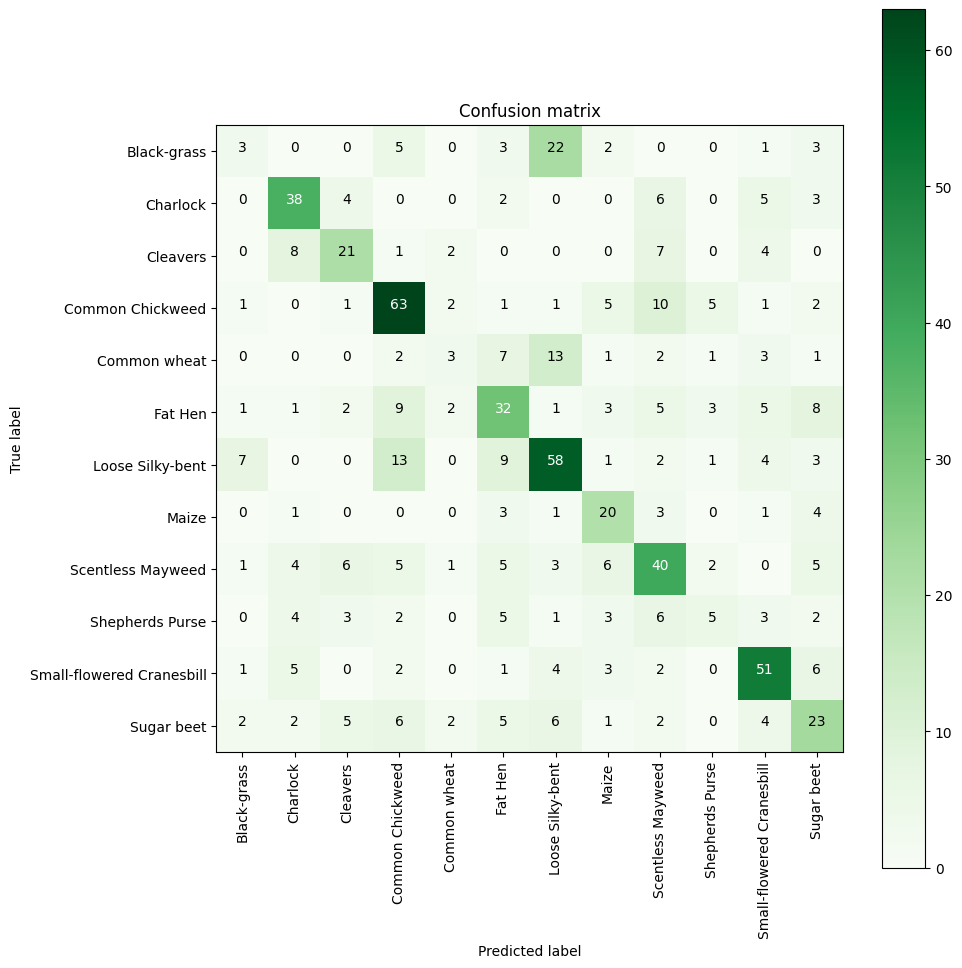

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)


history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3289 - loss: 2.3032 - precision: 0.4191 - recall: 0.2009 - val_accuracy: 0.0646 - val_loss: 8.5268 - val_precision: 0.0663 - val_recall: 0.0646
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5643 - loss: 1.3116 - precision: 0.6834 - recall: 0.4523 - val_accuracy: 0.5674 - val_loss: 1.5027 - val_precision: 0.6145 - val_recall: 0.5126
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6511 - loss: 1.0739 - precision: 0.7350 - recall: 0.5353 - val_accuracy: 0.6039 - val_loss: 1.4008 - val_precision: 0.6442 - val_recall: 0.5492
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6775 - loss: 0.9453 - precision: 0.7512 - recall: 0.5855 - val_accuracy: 0.4958 - val_loss: 2.2021 - val_precision: 0.5296 - val_recall: 0.4775
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7113 - loss: 0.8185 - precision: 0.7845 - recall: 0.6386 - val_accuracy: 0.6306 - val_loss: 

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6891 - loss: 1.6509 - precision: 0.6986 - recall: 0.6703


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Accuracy:  0.6970546841621399
Precision:  0.708695650100708
Recall:  0.685834527015686


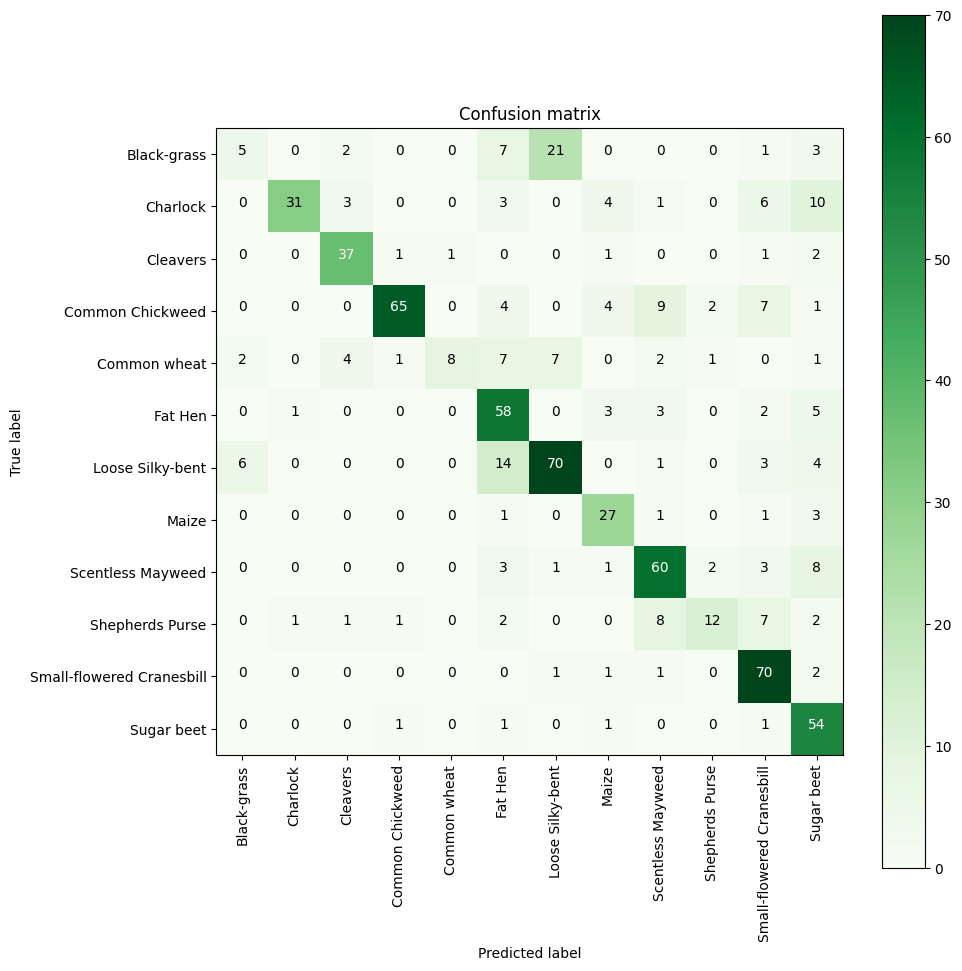

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 2, no callbacks

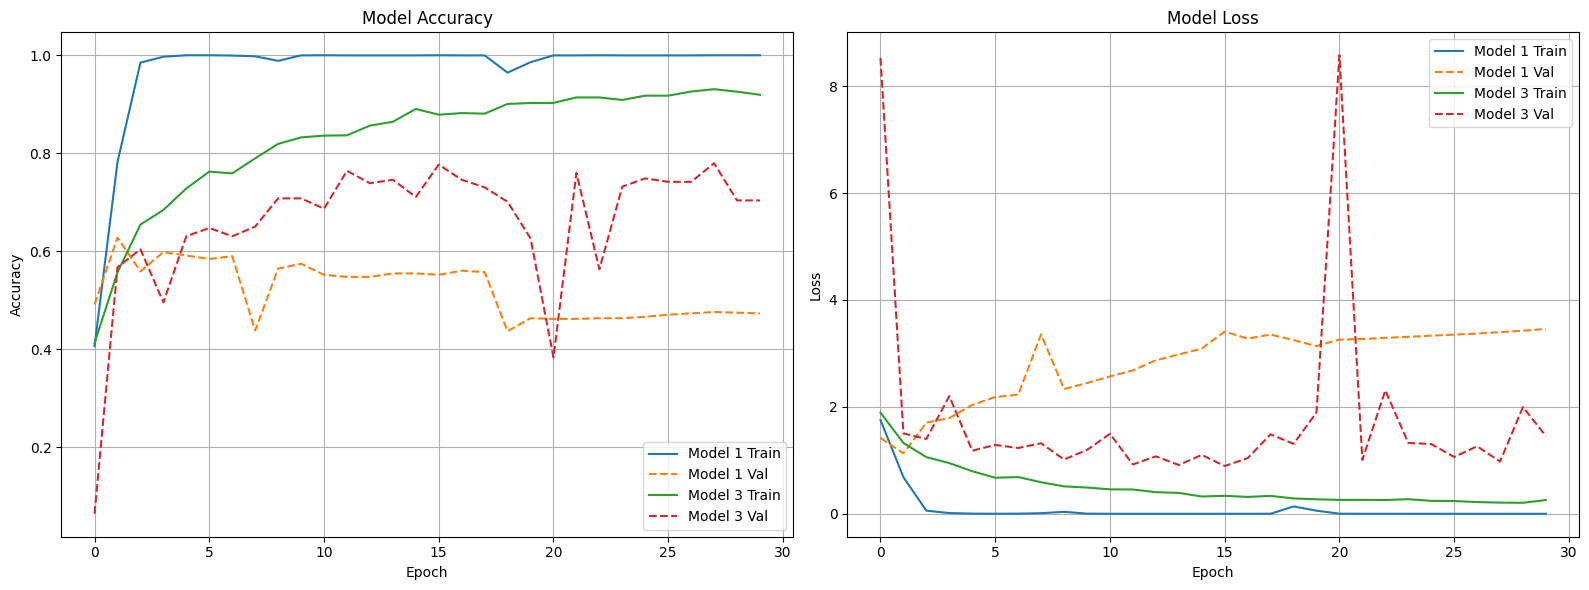

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running models with callbacks

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    callbacks = callbacks
)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3401 - loss: 1.9942 - precision: 0.5807 - recall: 0.1174 - val_accuracy: 0.4565 - val_loss: 1.4950 - val_precision: 0.7150 - val_recall: 0.2079 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7585 - loss: 0.7329 - precision: 0.8550 - recall: 0.6427 - val_accuracy: 0.4972 - val_loss: 1.6480 - val_precision: 0.5645 - val_recall: 0.4242 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9980 - loss: 0.0319 - precision: 0.9980 - recall: 0.9949 - val_accuracy: 0.5309 - val_loss: 2.2858 - val_precision: 0.5508 - val_recall: 0.5098 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9998 - loss: 0.0028 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.5309 - val_loss: 2.3133 - val_precision: 0.5394 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accur

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4430 - loss: 1.4906 - precision: 0.6862 - recall: 0.1906


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy:  0.4614305794239044
Precision:  0.6837209463119507
Recall:  0.20617111027240753


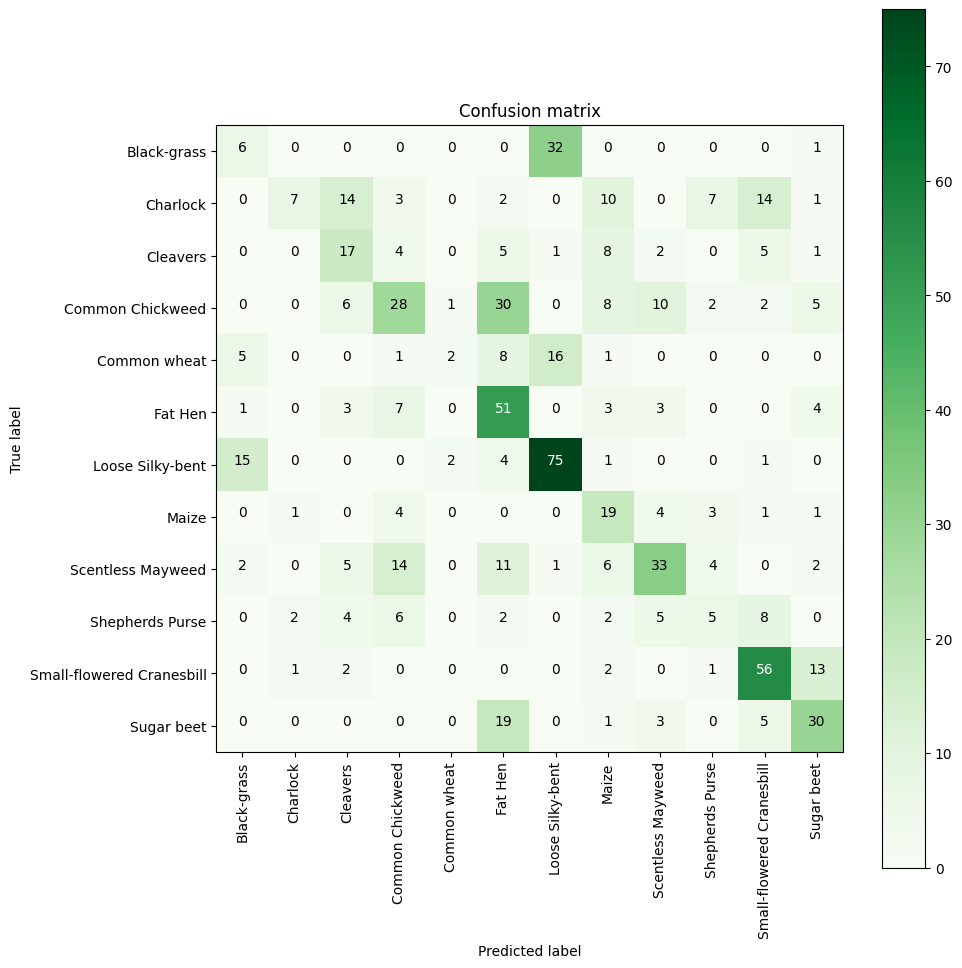

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True,
    callbacks = callbacks
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3140 - loss: 2.2876 - precision: 0.4085 - recall: 0.1942 - val_accuracy: 0.1390 - val_loss: 4.2762 - val_precision: 0.1878 - val_recall: 0.1124 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5633 - loss: 1.3037 - precision: 0.6806 - recall: 0.4479 - val_accuracy: 0.5309 - val_loss: 1.4418 - val_precision: 0.5788 - val_recall: 0.4747 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6324 - loss: 1.0627 - precision: 0.7275 - recall: 0.5445 - val_accuracy: 0.6390 - val_loss: 1.2085 - val_precision: 0.7030 - val_recall: 0.5618 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6875 - loss: 0.9128 - precision: 0.7609 - recall: 0.5992 - val_accuracy: 0.6039 - val_loss: 1.4111 - val_precision: 0.6532 - val_recall: 0.5688 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7803 - loss: 0.7329 - precision: 0.8166 - recall: 0.7704


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Accuracy:  0.8008415102958679
Precision:  0.8281481266021729
Recall:  0.7840112447738647


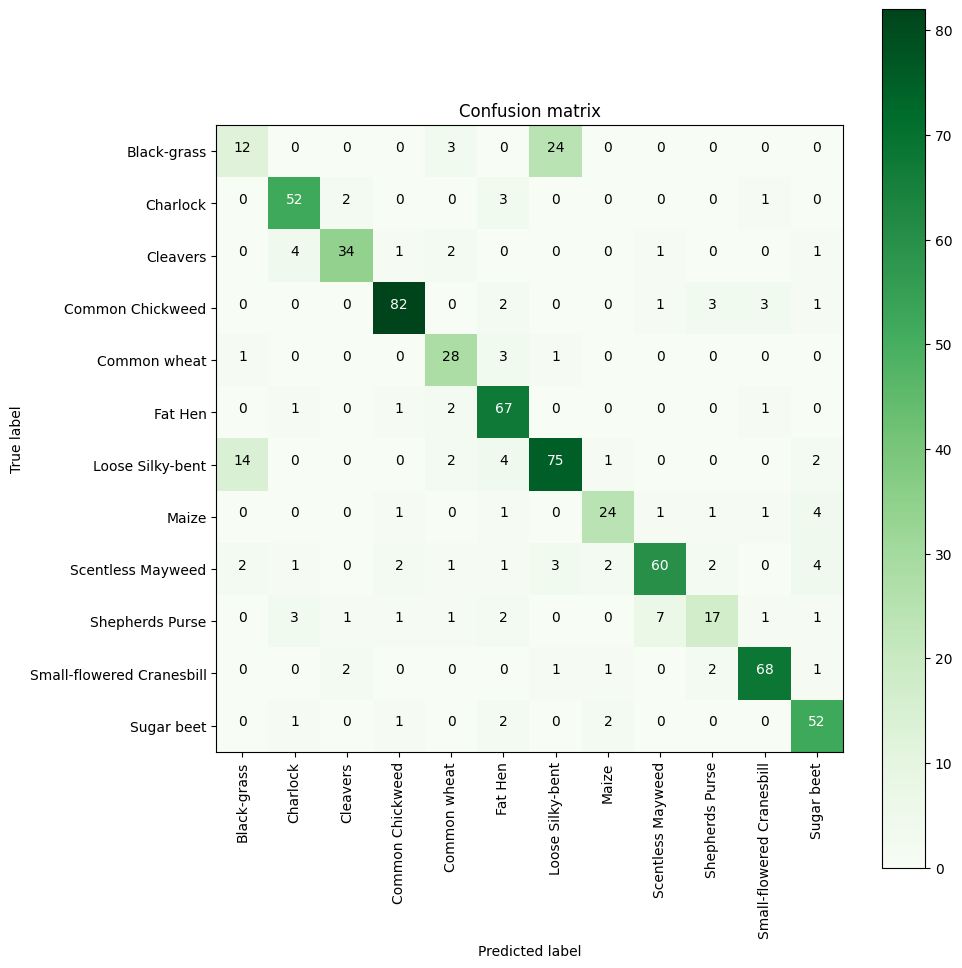

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 2, with callbacks

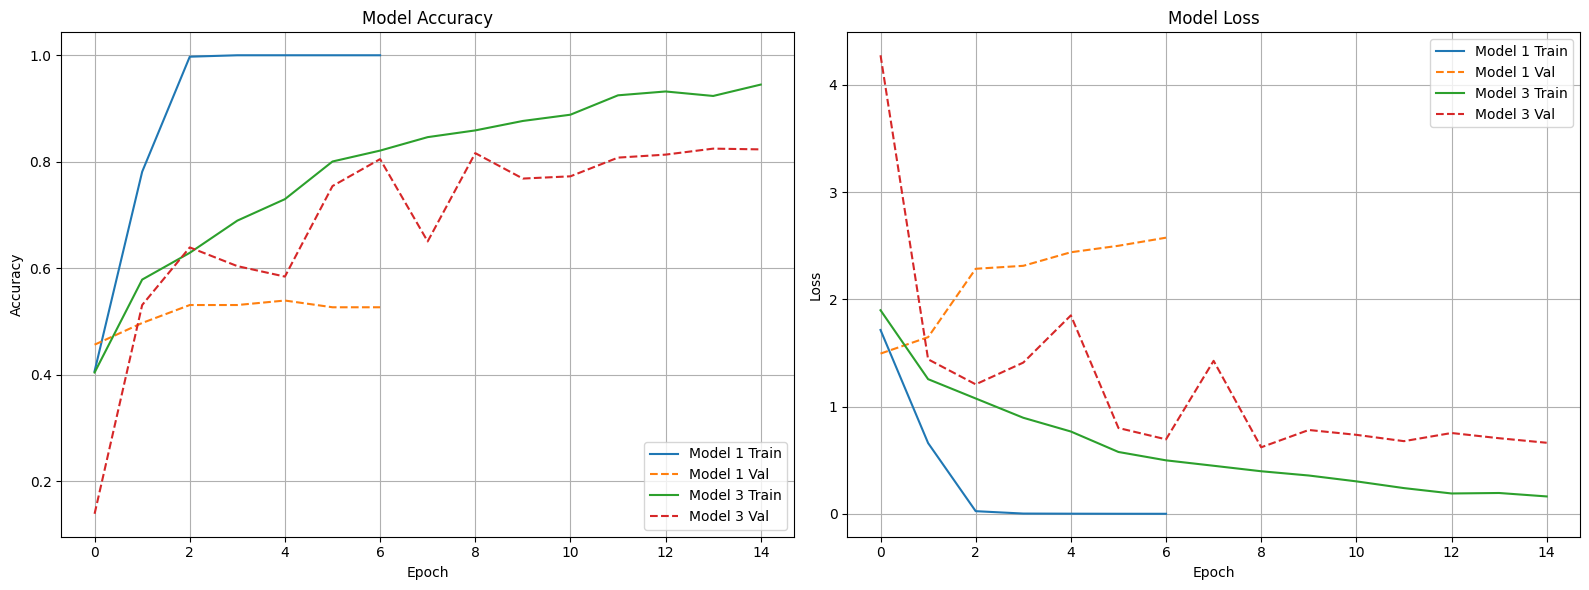

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Adding data-augmentation and running models with it

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_overfitted_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3452 - loss: 2.0314 - precision_29: 0.5336 - recall_29: 0.1190 - val_accuracy: 0.5885 - val_loss: 1.1766 - val_precision_29: 0.6861 - val_recall_29: 0.4635 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5994 - loss: 1.1667 - precision_29: 0.7157 - recall_29: 0.4520 - val_accuracy: 0.6924 - val_loss: 0.9504 - val_precision_29: 0.7668 - val_recall_29: 0.5913 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6725 - loss: 0.9555 - precision_29: 0.7753 - recall_29: 0.5783 - val_accuracy: 0.6756 - val_loss: 1.0224 - val_precision_29: 0.7368 - val_recall_29: 0.5899 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7440 - loss: 0.7783 - precision_29: 0.8043 - recall_29: 0.6703 - val_accuracy: 0.7149 - val_loss: 0.8209 - val_precision_29: 0.7870 - val_recall_29: 0.6643 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8197 - loss: 0.6018 - precision_29: 0.8425 - recall_29: 0.7921


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy:  0.8064516186714172
Precision:  0.8276374340057373
Recall:  0.7812061905860901


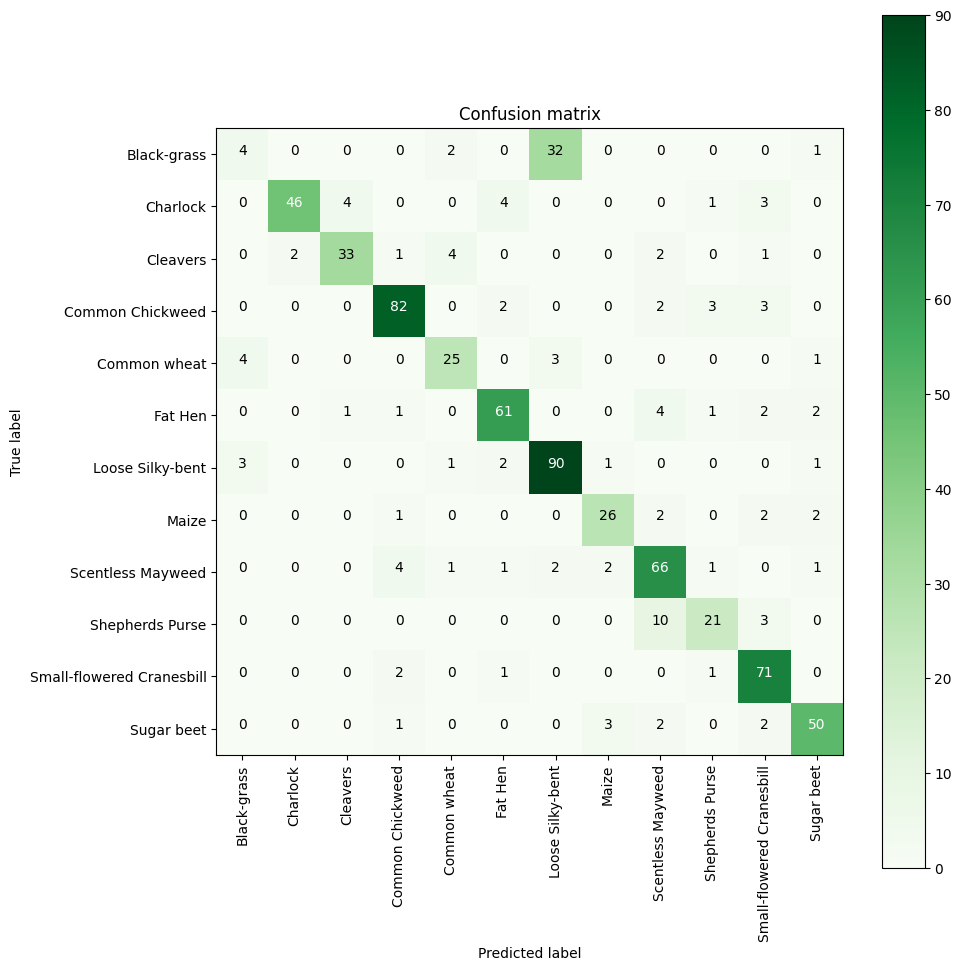

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_best_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3056 - loss: 2.3589 - precision_30: 0.3959 - recall_30: 0.1860 - val_accuracy: 0.0618 - val_loss: 9.5758 - val_precision_30: 0.0618 - val_recall_30: 0.0618 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4959 - loss: 1.5547 - precision_30: 0.6033 - recall_30: 0.3545 - val_accuracy: 0.5618 - val_loss: 1.6942 - val_precision_30: 0.6088 - val_recall_30: 0.4480 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5557 - loss: 1.3315 - precision_30: 0.6659 - recall_30: 0.4396 - val_accuracy: 0.5126 - val_loss: 1.9647 - val_precision_30: 0.5589 - val_recall_30: 0.4663 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6187 - loss: 1.1170 - precision_30: 0.7399 - recall_30: 0.5211 - val_accuracy: 0.5183 - val_loss: 1.7747 - val_precision_30: 0.5729 - val_recall_30: 0.4803 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8563 - loss: 0.4028 - precision_30: 0.8824 - recall_30: 0.8449


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy:  0.8527349233627319
Precision:  0.8759124279022217
Recall:  0.8415147066116333


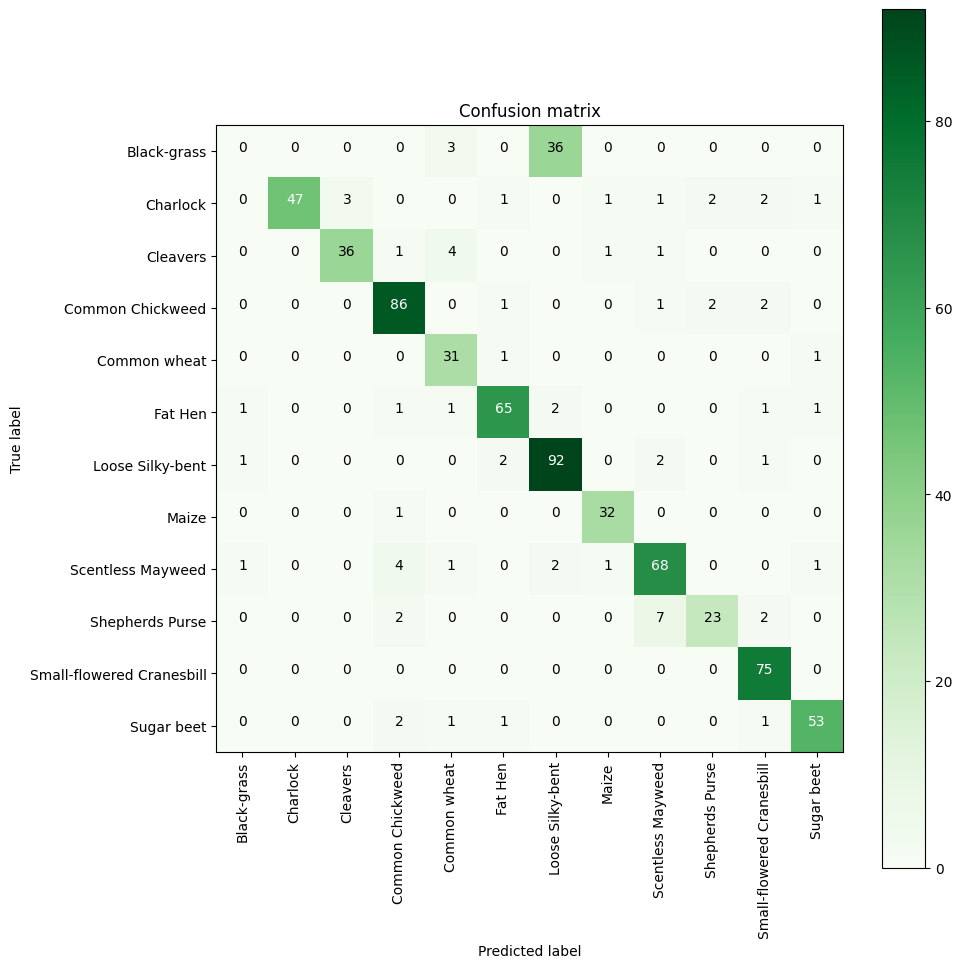

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 2, with callbacks and data augmentation

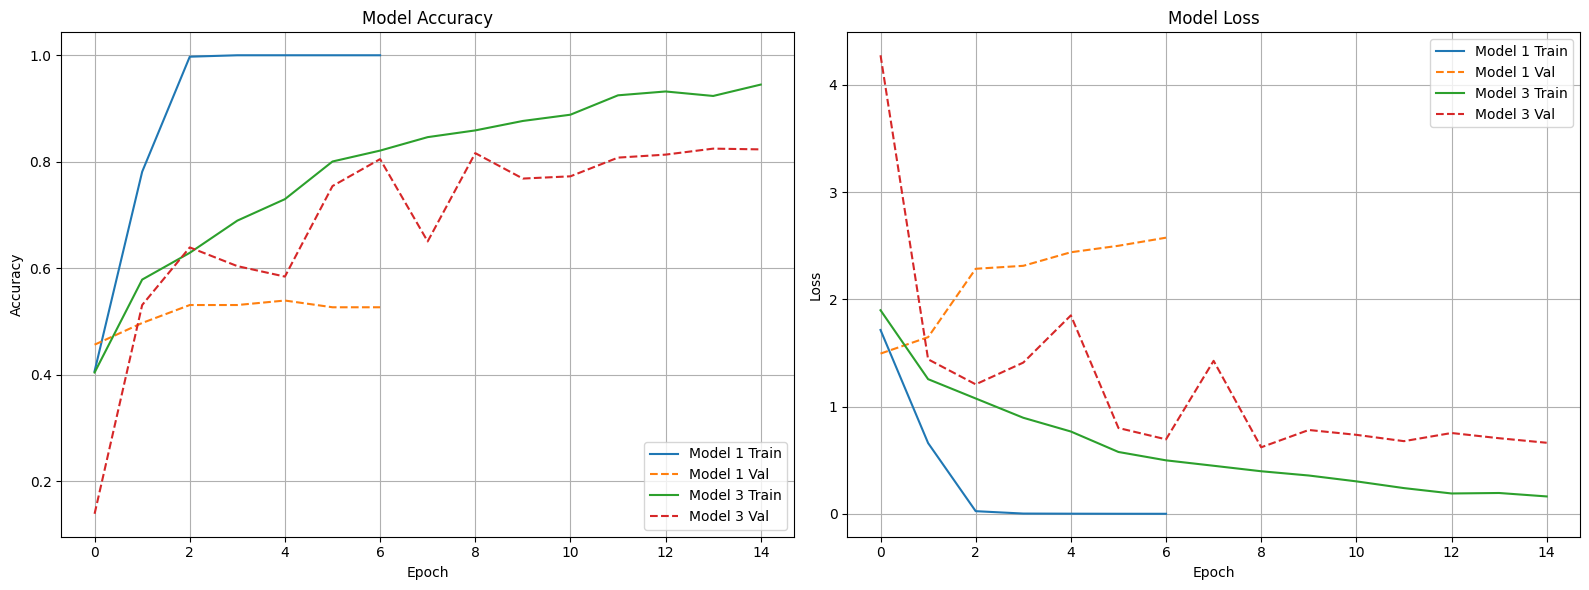

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running the pre-trained MobileNet model

In [ ]:
model = build_mobilenet_model(input_shape=ins, num_classes=12)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# 4. Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# 5. Augmented data generator
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# 6. Train the model
history_resnet = model.fit(
    train_gen,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.3302 - loss: 2.1512 - precision_32: 0.5470 - recall_32: 0.1477 - val_accuracy: 0.5590 - val_loss: 1.2799 - val_precision_32: 0.7192 - val_recall_32: 0.3525 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5429 - loss: 1.3226 - precision_32: 0.6869 - recall_32: 0.3794 - val_accuracy: 0.6503 - val_loss: 1.0343 - val_precision_32: 0.7479 - val_recall_32: 0.4916 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6117 - loss: 1.1062 - precision_32: 0.7372 - recall_32: 0.4723 - val_accuracy: 0.5941 - val_loss: 1.1828 - val_precision_32: 0.7170 - val_recall_32: 0.4803 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6595 - loss: 0.9732 - precision_32: 0.7611 - recall_32: 0.5369 - val_accuracy: 0.6657 - val_loss: 0.9851 - val_precision_32: 0.7619 - val_recall_32: 0.5618 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7387 - loss: 0.7984 - precision_32: 0.7997 - recall_32: 0.6791


## Results of pre-trained model

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
Accuracy:  0.739130437374115
Precision:  0.8026756048202515
Recall:  0.6732117533683777


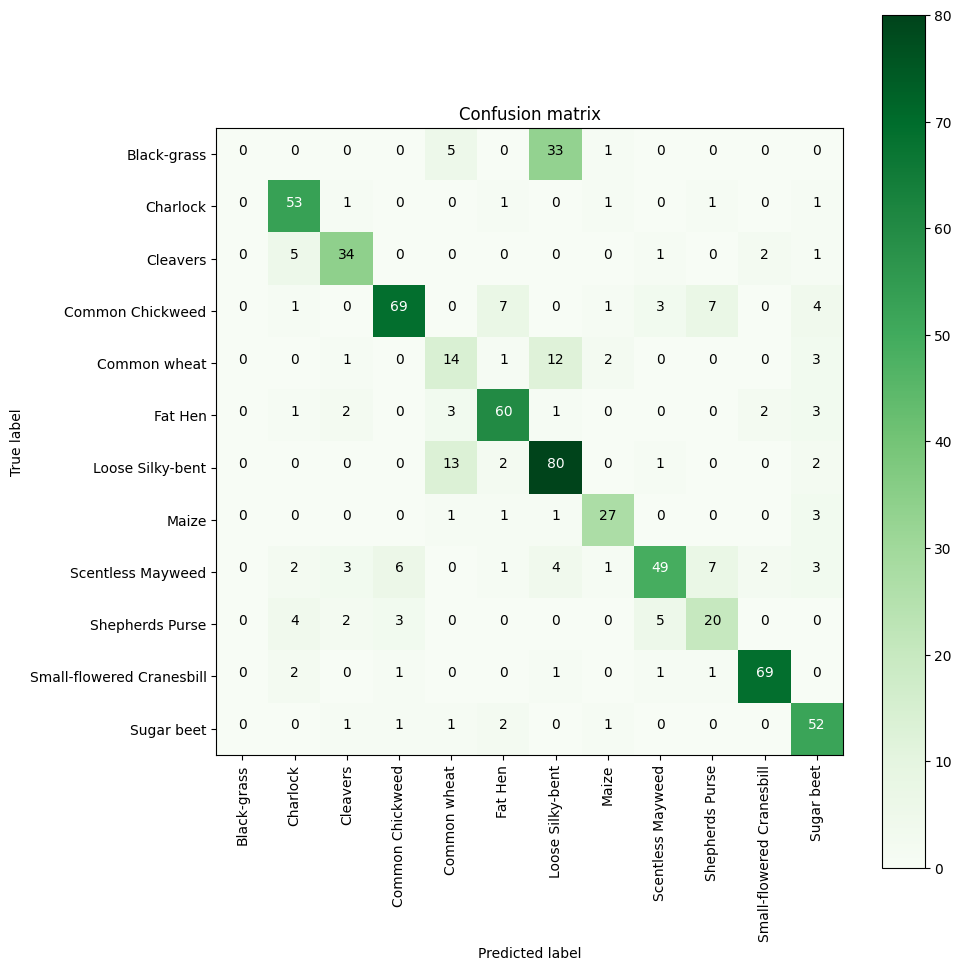

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



# Approach 3 - Deleting grayscale images






In [ ]:
import os

# List of known grayscale or unreadable image paths
bad_images = [
    "train/Black-grass/ae8f69724.png",
    "train/Black-grass/77629b9e3.png",
    "train/Black-grass/a8ab1ff26.png",
    "train/Loose Silky-bent/e513efb9a.png",
    "train/Loose Silky-bent/875ef92d7.png",
    "train/Loose Silky-bent/4a0df8be4.png",
    "train/Loose Silky-bent/df615189b.png",
    "train/Loose Silky-bent/ab47c78db.png",
    "train/Loose Silky-bent/881498f15.png",
    "train/Loose Silky-bent/b81690ccf.png",
    "train/Loose Silky-bent/d1653b4c3.png",
    "train/Loose Silky-bent/3fd2b83fc.png",
    "train/Loose Silky-bent/180a7bc07.png",
    "train/Loose Silky-bent/f5602e151.png",
    "train/Loose Silky-bent/3d9f8222d.png",
    "train/Loose Silky-bent/7a8370ede.png",
    "train/Loose Silky-bent/780b7ab63.png",
    "train/Loose Silky-bent/9cf880bda.png",
    "train/Loose Silky-bent/0cf9eb4ab.png",
    "train/Loose Silky-bent/5cb45767e.png",
    "train/Loose Silky-bent/ae1c97a42.png",
    "train/Loose Silky-bent/7324d3cc4.png",
    "train/Loose Silky-bent/02b15993e.png",
    "train/Loose Silky-bent/d31724b7f.png",
]

# Delete each file if it exists
for file_path in bad_images:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")


Deleted: train/Black-grass/ae8f69724.png
Deleted: train/Black-grass/77629b9e3.png
Deleted: train/Black-grass/a8ab1ff26.png
Deleted: train/Loose Silky-bent/e513efb9a.png
Deleted: train/Loose Silky-bent/875ef92d7.png
Deleted: train/Loose Silky-bent/4a0df8be4.png
Deleted: train/Loose Silky-bent/df615189b.png
Deleted: train/Loose Silky-bent/ab47c78db.png
Deleted: train/Loose Silky-bent/881498f15.png
Deleted: train/Loose Silky-bent/b81690ccf.png
Deleted: train/Loose Silky-bent/d1653b4c3.png
Deleted: train/Loose Silky-bent/3fd2b83fc.png
Deleted: train/Loose Silky-bent/180a7bc07.png
Deleted: train/Loose Silky-bent/f5602e151.png
Deleted: train/Loose Silky-bent/3d9f8222d.png
Deleted: train/Loose Silky-bent/7a8370ede.png
Deleted: train/Loose Silky-bent/780b7ab63.png
Deleted: train/Loose Silky-bent/9cf880bda.png
Deleted: train/Loose Silky-bent/0cf9eb4ab.png
Deleted: train/Loose Silky-bent/5cb45767e.png
Deleted: train/Loose Silky-bent/ae1c97a42.png
Deleted: train/Loose Silky-bent/7324d3cc4.png
Del

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

# Parameters
IMG_SIZE = 96
DATASET_DIR = "train"

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            # Open image, convert to RGB and resize
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0  # Normalize to 0–1
            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")


Images loaded and resized
Image shape: (4726, 96, 96, 3)
Unique classes: 12


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Create label-to-index mapping
label_to_index = {label: idx for idx, label in enumerate(np.unique(y))}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Encode string labels to integer indices
y_encoded = np.array([label_to_index[label] for label in y])

# One-hot encode labels
y_categorical = to_categorical(y_encoded, num_classes=len(label_to_index))

# Split 1: train and test1 (70% / 30%)
X_train, X_test1, y_train, y_test1 = train_test_split(
    X, y_categorical, test_size=0.30, stratify=y_categorical, random_state=42
)

# Split 2: test1 into val and test (50%/50% of 30% => 15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test1, y_test1, test_size=0.50, stratify=y_test1, random_state=42
)


print("Labels encoded and data split finished.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Labels encoded and data split finished.
X_train shape: (3308, 96, 96, 3)
y_train shape: (3308, 12)
X_val shape:   (709, 96, 96, 3)
y_val shape:   (709, 12)
X_test shape:  (709, 96, 96, 3)
y_test shape:  (709, 12)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Ustawienia dla segmentacji zieleni ---
lower_green = (25, 40, 50)
upper_green = (75, 255, 255)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

# --- Funkcja preprocessingu ---
def preprocess_images(X):
    preprocessed = []
    for img in X:
        # 1. Zamiana na uint8 (0–255)
        img_uint8 = (img * 255).astype(np.uint8)

        # 2. (Opcjonalnie resize - u Ciebie obrazy są 224x224, więc nie zmniejszamy!)
        resize_img = img_uint8

        # 3. Rozmycie Gaussa
        Gblur_img = cv2.GaussianBlur(resize_img, (3, 3), 0)

        # 4. Konwersja do HSV
        hsv_img = cv2.cvtColor(Gblur_img, cv2.COLOR_RGB2HSV)  # RGB -> HSV

        # 5. Segmentacja zieleni
        mask = cv2.inRange(hsv_img, lower_green, upper_green)

        # 6. Morfologiczne operacje czyszczące
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 7. Boolean mask
        bMask = mask > 0

        # 8. Nałożenie maski na obraz
        clearImg = np.zeros_like(resize_img, np.uint8)
        clearImg[bMask] = resize_img[bMask]

        # 9. Konwersja do float32 (0–1)
        clearImg_float = clearImg.astype(np.float32) / 255.0

        preprocessed.append(clearImg_float)

    return np.asarray(preprocessed)

# --- Preprocessing Twoich danych (przykład dla X_train) ---
X_train_cleaned = preprocess_images(X_train)
X_val_cleaned = preprocess_images(X_val)
X_test_cleaned = preprocess_images(X_test)


## Running models with no callbacks to see the performance

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3074 - loss: 2.0841 - precision: 0.5208 - recall: 0.1221 - val_accuracy: 0.6192 - val_loss: 1.1648 - val_precision: 0.7129 - val_recall: 0.5360
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7928 - loss: 0.6356 - precision: 0.8572 - recall: 0.7261 - val_accuracy: 0.6164 - val_loss: 1.2164 - val_precision: 0.6960 - val_recall: 0.5585
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9879 - loss: 0.0585 - precision: 0.9905 - recall: 0.9812 - val_accuracy: 0.6248 - val_loss: 1.6598 - val_precision: 0.6530 - val_recall: 0.6051
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9998 - loss: 0.0035 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.6291 - val_loss: 1.8816 - val_precision: 0.6602 - val_recall: 0.6192
Epoch 5/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 1.0000 - loss: 9.4773e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6234 - val_los

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5846 - loss: 3.3115 - precision: 0.5955 - recall: 0.5805


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy:  0.5895627737045288
Precision:  0.5965417623519897
Recall:  0.5839210152626038


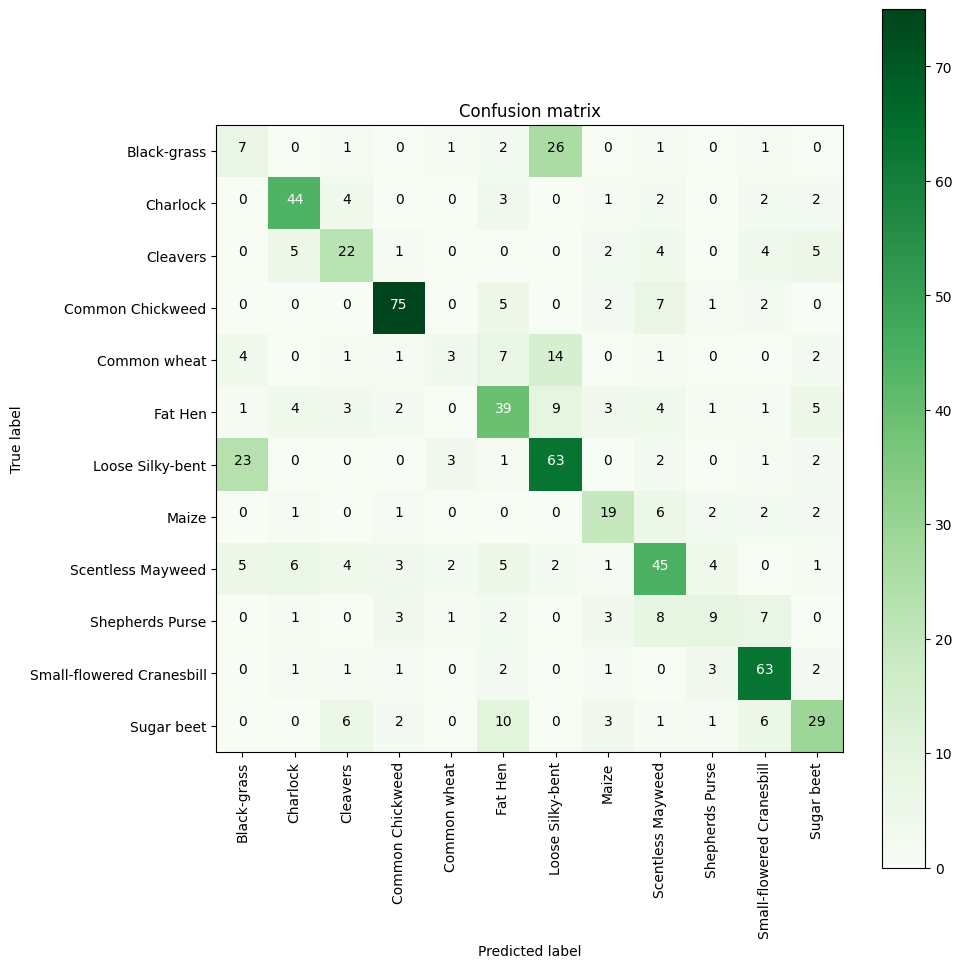

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)


history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True
    )


Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2868 - loss: 2.3512 - precision: 0.4106 - recall: 0.1773 - val_accuracy: 0.0606 - val_loss: 9.4708 - val_precision: 0.0606 - val_recall: 0.0606
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5643 - loss: 1.3252 - precision: 0.6630 - recall: 0.4492 - val_accuracy: 0.6276 - val_loss: 1.2080 - val_precision: 0.6833 - val_recall: 0.5811
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6389 - loss: 1.0950 - precision: 0.7257 - recall: 0.5363 - val_accuracy: 0.5698 - val_loss: 1.5123 - val_precision: 0.6209 - val_recall: 0.5360
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6553 - loss: 0.9797 - precision: 0.7386 - recall: 0.5629 - val_accuracy: 0.6601 - val_loss: 1.0057 - val_precision: 0.7293 - val_recall: 0.5853
Epoch 5/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7198 - loss: 0.7966 - precision: 0.8105 - recall: 0.6474 - val_accuracy: 0.7320 - val_loss: 

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8277 - loss: 0.7196 - precision: 0.8483 - recall: 0.8207


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy:  0.8095909953117371
Precision:  0.8304093480110168
Recall:  0.8011283278465271


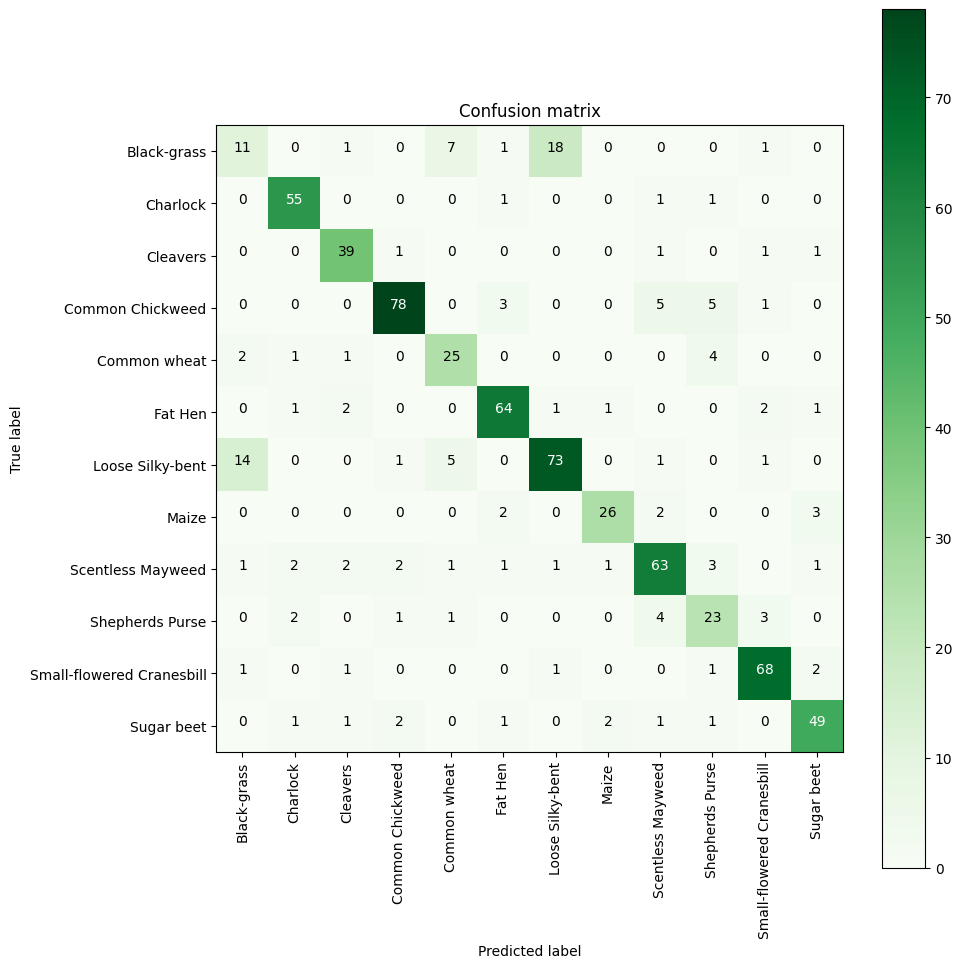

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 3, no callbacks

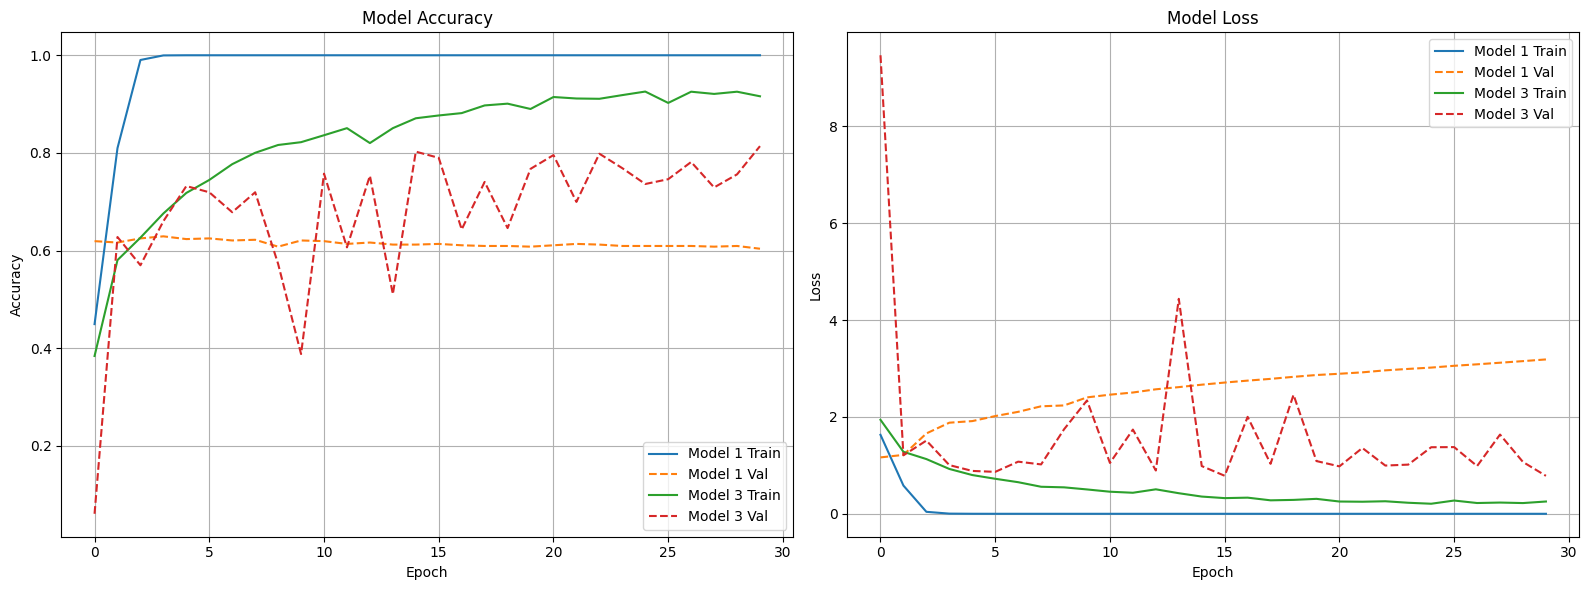

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running models with callbacks

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_overfitted_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    callbacks = callbacks
)

Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3889 - loss: 1.7979 - precision: 0.6012 - recall: 0.1978 - val_accuracy: 0.6559 - val_loss: 1.0828 - val_precision: 0.7401 - val_recall: 0.5543 - learning_rate: 0.0010
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8628 - loss: 0.4237 - precision: 0.8978 - recall: 0.8222 - val_accuracy: 0.6657 - val_loss: 1.0727 - val_precision: 0.7104 - val_recall: 0.6192 - learning_rate: 0.0010
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9951 - loss: 0.0286 - precision: 0.9955 - recall: 0.9948 - val_accuracy: 0.6403 - val_loss: 1.5457 - val_precision: 0.6682 - val_recall: 0.6276 - learning_rate: 0.0010
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9993 - loss: 0.0032 - precision: 0.9993 - recall: 0.9993 - val_accuracy: 0.6121 - val_loss: 2.0607 - val_precision: 0.6246 - val_recall: 0.5938 - learning_rate: 0.0010
Epoch 5/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy:

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6670 - loss: 1.1101 - precision: 0.7104 - recall: 0.6065


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy:  0.6614950895309448
Precision:  0.7107023596763611
Recall:  0.5994358062744141


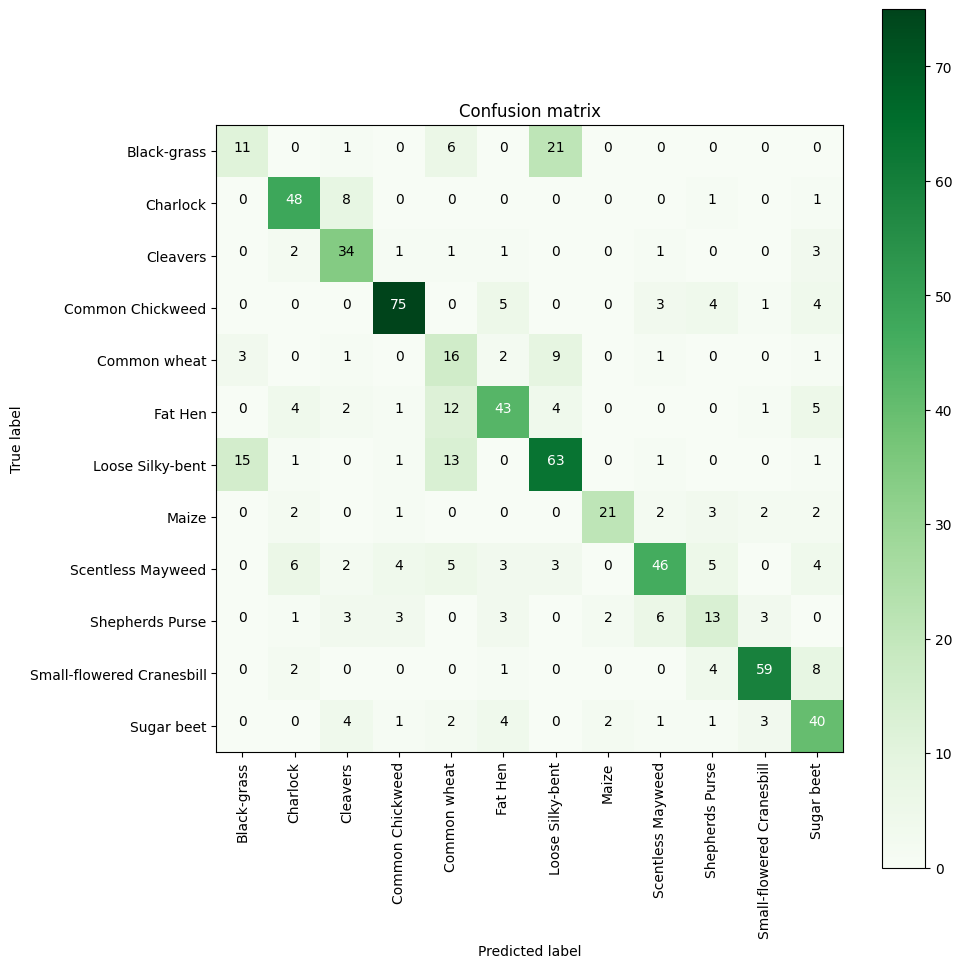

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

model = build_best_model()

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history3 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    shuffle = True,
    callbacks = callbacks
    )


Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3308 - loss: 2.2173 - precision: 0.4485 - recall: 0.2159 - val_accuracy: 0.0606 - val_loss: 6.1214 - val_precision: 0.0607 - val_recall: 0.0606 - learning_rate: 0.0010
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5514 - loss: 1.3589 - precision: 0.6333 - recall: 0.4292 - val_accuracy: 0.5867 - val_loss: 1.2812 - val_precision: 0.6425 - val_recall: 0.5247 - learning_rate: 0.0010
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6460 - loss: 1.0366 - precision: 0.7266 - recall: 0.5450 - val_accuracy: 0.6291 - val_loss: 1.0721 - val_precision: 0.7081 - val_recall: 0.5543 - learning_rate: 0.0010
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6903 - loss: 0.8938 - precision: 0.7643 - recall: 0.5994 - val_accuracy: 0.6996 - val_loss: 0.9656 - val_precision: 0.7439 - val_recall: 0.6432 - learning_rate: 0.0010
Epoch 5/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8551 - loss: 0.5402 - precision: 0.8674 - recall: 0.8423


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy:  0.8490832448005676
Precision:  0.863173246383667
Recall:  0.8363893032073975


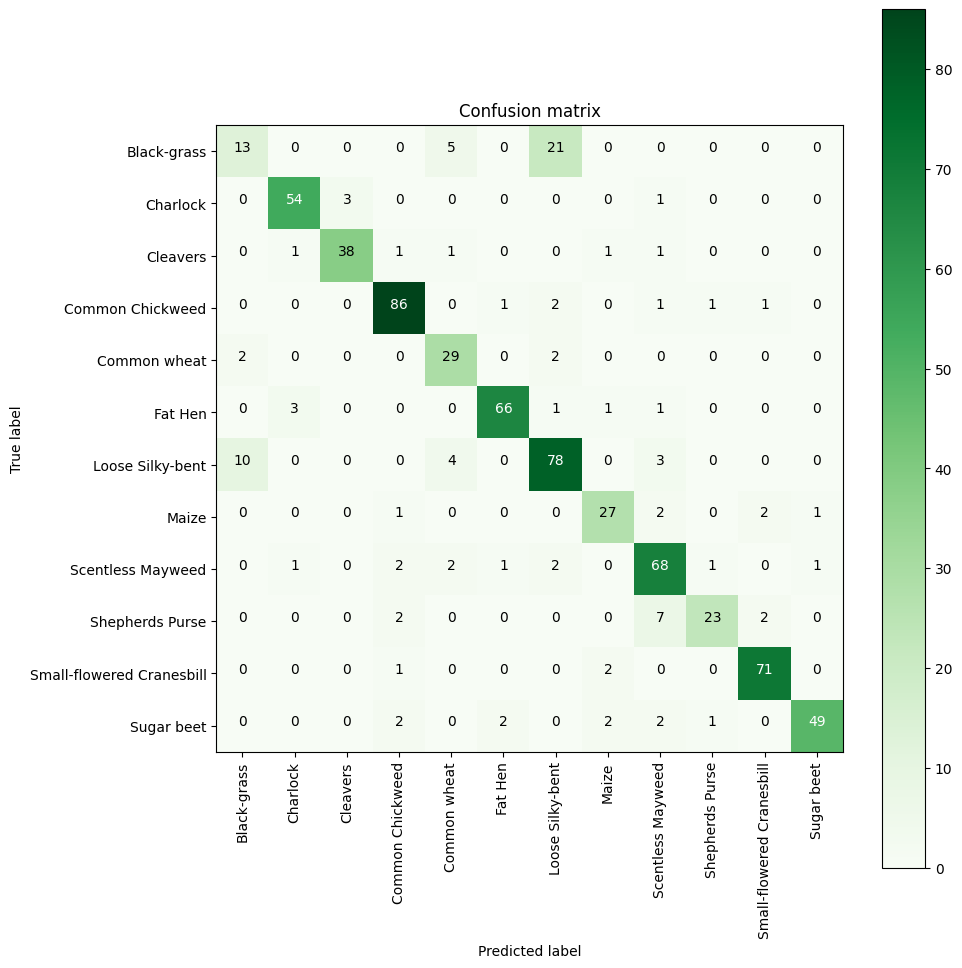

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 3, with callbacks

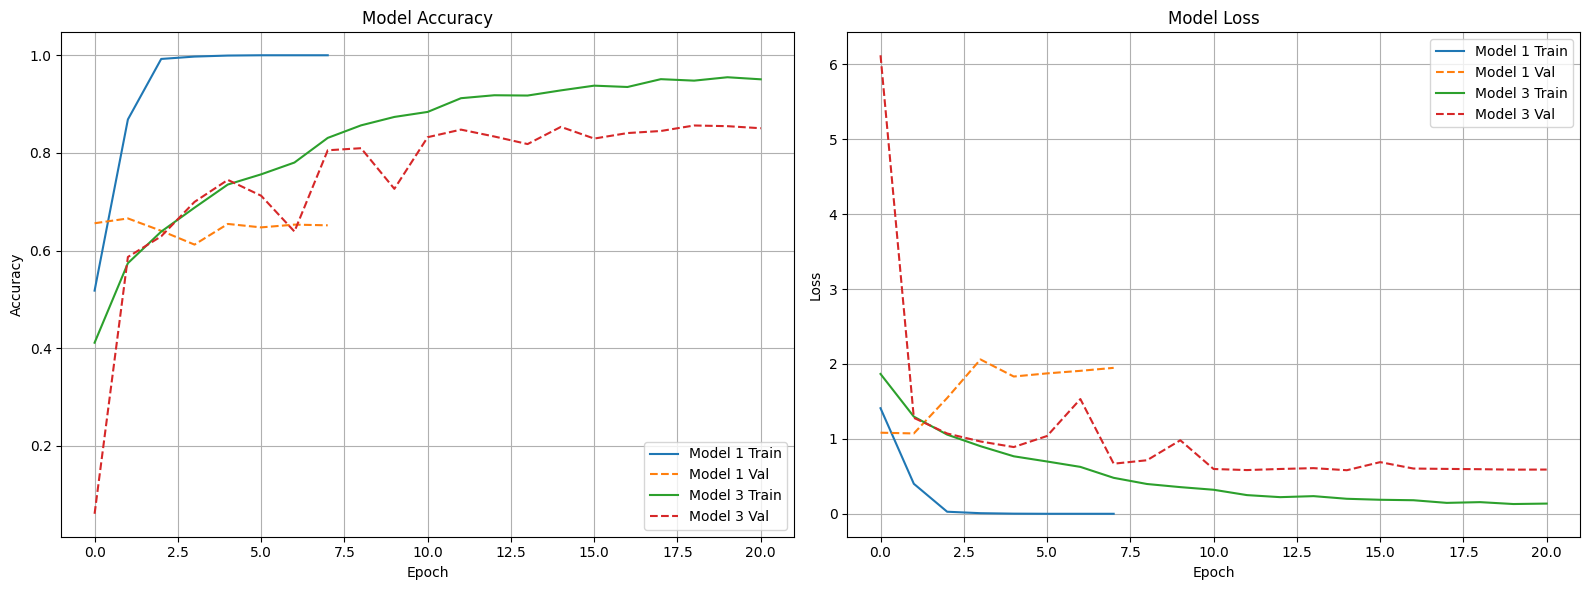

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Adding data-augmentation and running models with it

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_overfitted_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3625 - loss: 1.8815 - precision_37: 0.5986 - recall_37: 0.1468 - val_accuracy: 0.6615 - val_loss: 1.0981 - val_precision_37: 0.7385 - val_recall_37: 0.5656 - learning_rate: 0.0010
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6319 - loss: 1.1257 - precision_37: 0.7398 - recall_37: 0.4961 - val_accuracy: 0.7080 - val_loss: 0.9359 - val_precision_37: 0.8004 - val_recall_37: 0.5994 - learning_rate: 0.0010
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7037 - loss: 0.8648 - precision_37: 0.7875 - recall_37: 0.6104 - val_accuracy: 0.6911 - val_loss: 0.9443 - val_precision_37: 0.7590 - val_recall_37: 0.6262 - learning_rate: 0.0010
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7017 - loss: 0.8597 - precision_37: 0.7767 - recall_37: 0.6253 - val_accuracy: 0.7405 - val_loss: 0.8513 - val_precision_37: 0.7818 - val_recall_37: 0.6925 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8194 - loss: 0.6162 - precision_37: 0.8488 - recall_37: 0.8090


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy:  0.8166431784629822
Precision:  0.8439821600914001
Recall:  0.8011283278465271


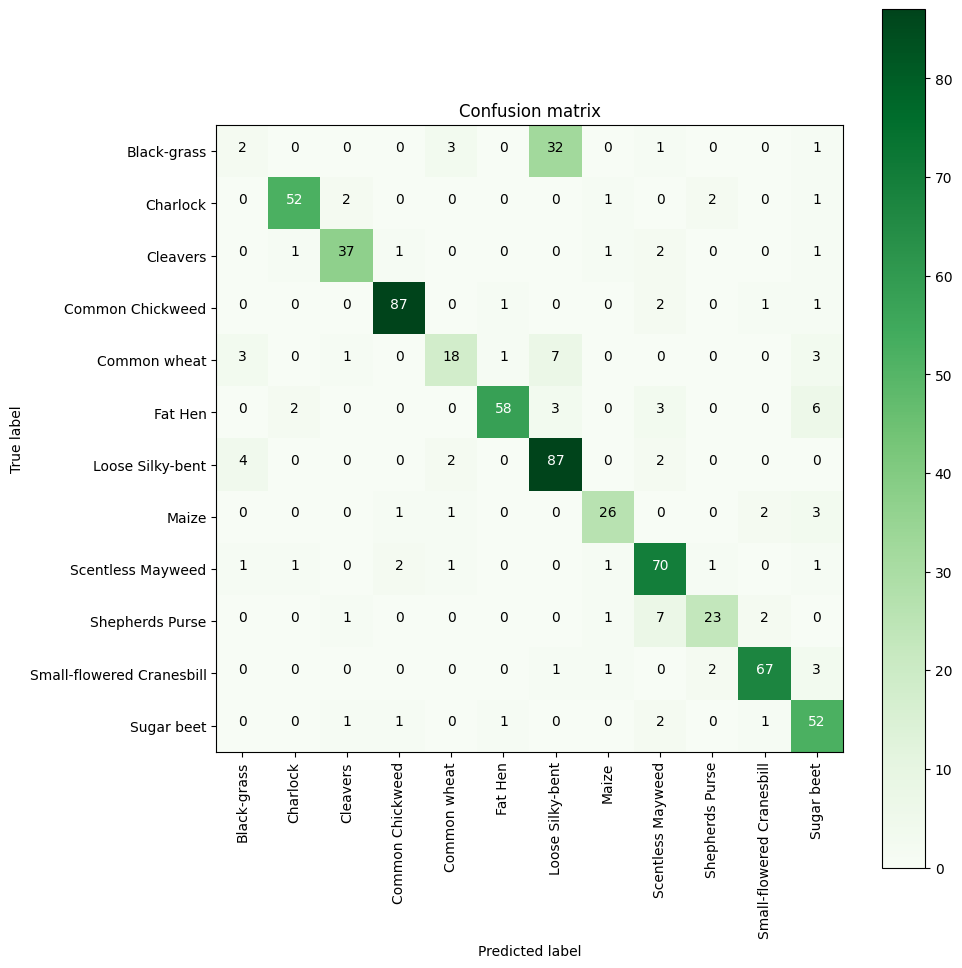

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Build the best model (architecture stays the same – data will be augmented)
model = build_best_model()  # you don't need a separate "build_augmented_best_model"

# Compile the model with optimizer, loss function and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Create data generator with real-time augmentation
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# Train the model using the generator
history_augmented = model.fit(
    train_gen,                                    # training data with augmentation
    validation_data=(X_val_cleaned, y_val),       # static validation set
    epochs=30,
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.2823 - loss: 2.4203 - precision_38: 0.3758 - recall_38: 0.1581 - val_accuracy: 0.0677 - val_loss: 4.7122 - val_precision_38: 0.0696 - val_recall_38: 0.0677 - learning_rate: 0.0010
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4786 - loss: 1.5297 - precision_38: 0.5958 - recall_38: 0.3623 - val_accuracy: 0.5585 - val_loss: 1.5552 - val_precision_38: 0.5943 - val_recall_38: 0.4979 - learning_rate: 0.0010
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5609 - loss: 1.3197 - precision_38: 0.6641 - recall_38: 0.4307 - val_accuracy: 0.4922 - val_loss: 1.7474 - val_precision_38: 0.5758 - val_recall_38: 0.4288 - learning_rate: 0.0010
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6150 - loss: 1.1478 - precision_38: 0.7102 - recall_38: 0.5005 - val_accuracy: 0.6121 - val_loss: 1.2791 - val_precision_38: 0.6907 - val_recall_38: 0.5543 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3821 - precision_38: 0.8840 - recall_38: 0.8639


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Accuracy:  0.871650218963623
Precision:  0.8855072259902954
Recall:  0.861777126789093


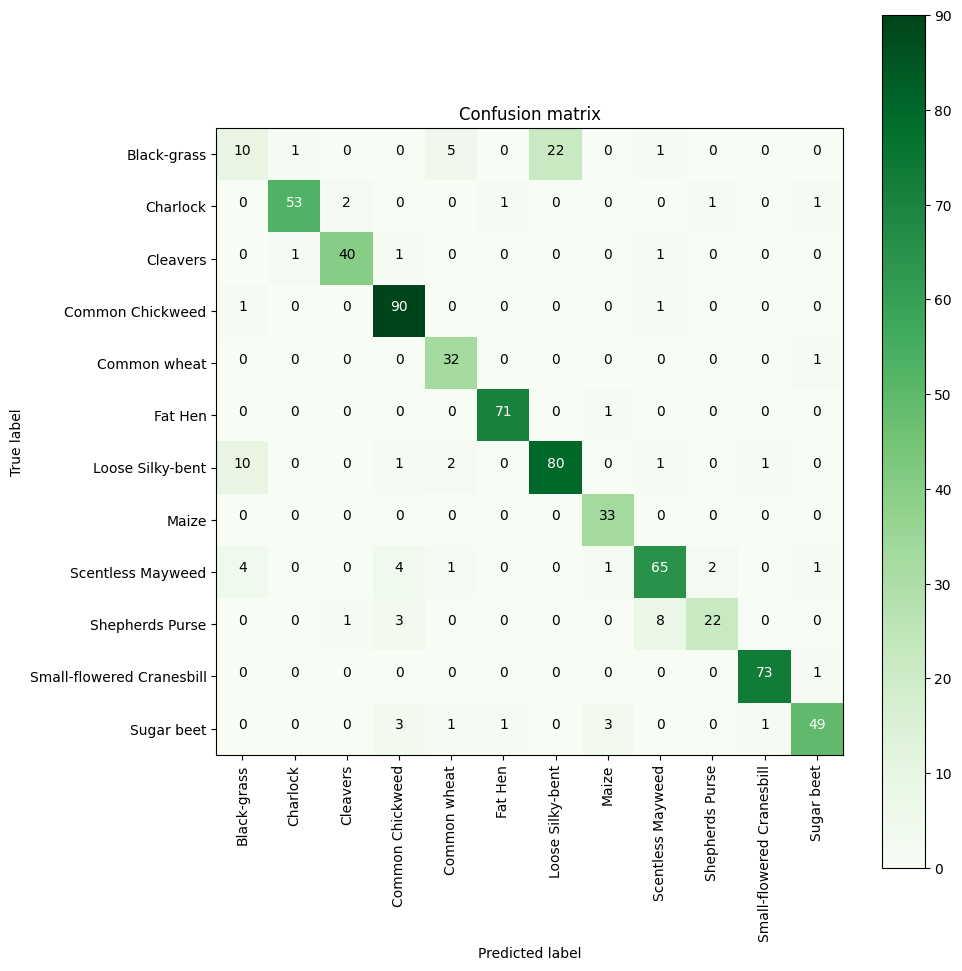

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



## Model comparison - approach 3, with callbacks and data augmentation

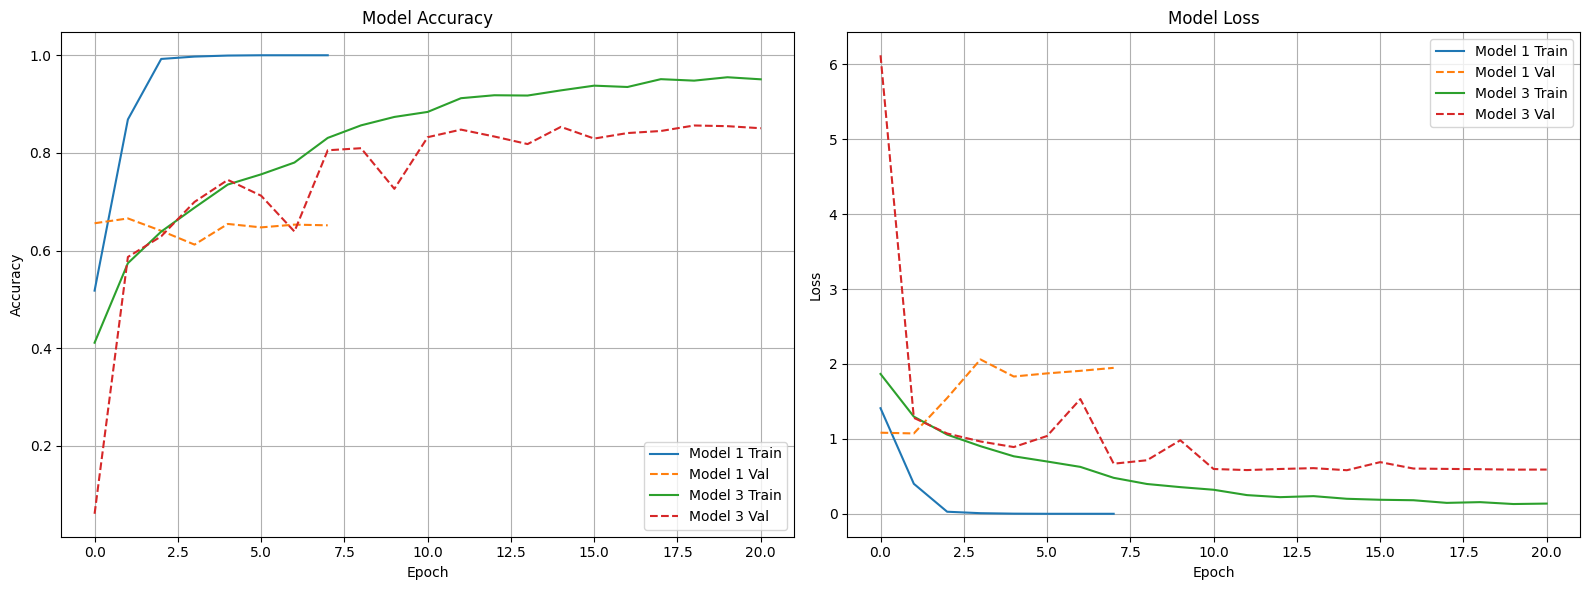

In [ ]:
import matplotlib.pyplot as plt


def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    "Model 1": history1.history if 'history1' in globals() else None,
    "Model 3": history3.history if 'history3' in globals() else None
}

plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if h:
        plt.plot(h['loss'], label=f'{name} Train')
        plt.plot(h['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Running the pre-trained MobileNet model

In [ ]:
model = build_mobilenet_model(input_shape=ins, num_classes=12)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# 4. Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# 5. Augmented data generator
train_gen = get_augmented_generator(X_train_cleaned, y_train, batch_size=8)

# 6. Train the model
history_resnet = model.fit(
    train_gen,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.3309 - loss: 2.1252 - precision_39: 0.5384 - recall_39: 0.1352 - val_accuracy: 0.4048 - val_loss: 1.6136 - val_precision_39: 0.5528 - val_recall_39: 0.2807 - learning_rate: 0.0010
Epoch 2/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5456 - loss: 1.2909 - precision_39: 0.7024 - recall_39: 0.3475 - val_accuracy: 0.5444 - val_loss: 1.2718 - val_precision_39: 0.7171 - val_recall_39: 0.4076 - learning_rate: 0.0010
Epoch 3/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5918 - loss: 1.1331 - precision_39: 0.7120 - recall_39: 0.4363 - val_accuracy: 0.6714 - val_loss: 0.9538 - val_precision_39: 0.7869 - val_recall_39: 0.5416 - learning_rate: 0.0010
Epoch 4/30
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6425 - loss: 0.9948 - precision_39: 0.7556 - recall_39: 0.5011 - val_accuracy: 0.5980 - val_loss: 1.1151 - val_precision_39: 0.7551 - val_recall_39: 0.4739 - learning_rate: 0.0010
Epoch 5/30


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7491 - loss: 0.7479 - precision_39: 0.8166 - recall_39: 0.6942


## Results of pre-trained model

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step
Accuracy:  0.7404795289039612
Precision:  0.8149999976158142
Recall:  0.6897038221359253


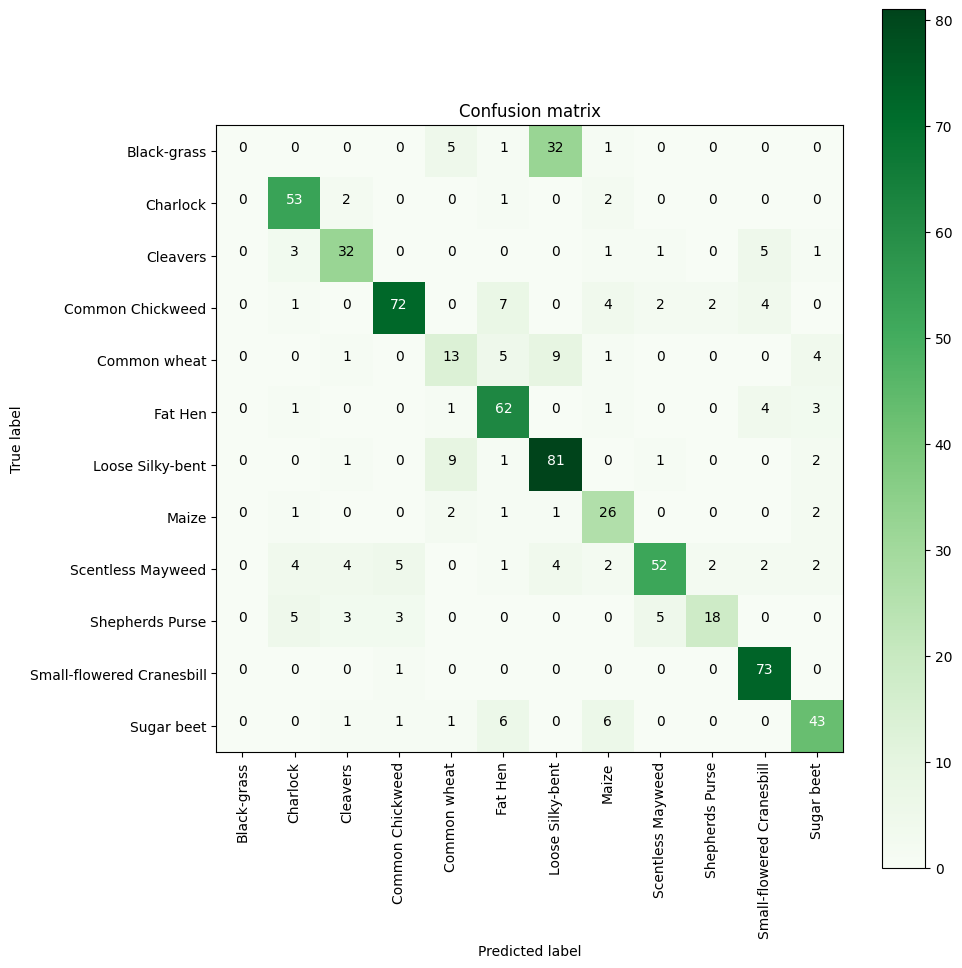

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)   # Wyciągnięcie klasy
trueY = np.argmax(y_test, axis=1)          # Wyciągnięcie prawdziwej klasy

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Lista nazw klas (Twoje index_to_label) ---
categ = list(index_to_label.values())   # Zamieniamy dict na listę nazw

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False)

print("Accuracy: ", results[1])
print("Precision: ", results[2])
print("Recall: ", results[3])



# Comparing results from different approaches